# Preprocessing steps for _GlobalPID_ models

In [1]:
LOCAL = True
SAMPLE = "2016MU"

### Technologies and libraries

On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import uproot
import numpy as np
import pandas as pd
import dask.dataframe as ddf

from os import environ

### Loading data

In [3]:
from glob import glob

if LOCAL:
    if SAMPLE == "2016MU":
        file_pattern = "/afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root"
    else:
        pass
else:
    # file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j109/*.root"
    pass

default_file_list = glob(file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} files from {file_pattern}")  

Found 236 files from /afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root


#### Conversion from `ROOT TTree` to `Pandas DataFrame`

In [4]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

## `isMuon` passed

In [5]:
selections_im = [
  "probe_Brunel_P > 3000",
  "probe_Brunel_P < 200000", 
  "probe_Brunel_ETA > 1.5", 
  "probe_Brunel_ETA < 5.5", 
  "probe_Brunel_isMuon == 1", 
  "probe_Brunel_RichDLLe  > -150",
  "probe_Brunel_RichDLLmu > -150",
  "probe_Brunel_RichDLLk  > -150",
  "probe_Brunel_RichDLLp  > -150",
  "probe_Brunel_RichDLLe  <  150",
  "probe_Brunel_RichDLLmu <  150",
  "probe_Brunel_RichDLLk  <  150",
  "probe_Brunel_RichDLLp  <  150",
  "probe_Brunel_MuonMuLL > -9",
  "probe_Brunel_MuonBgLL > -9", 
  "probe_Brunel_MuonMuLL <  1", 
  "probe_Brunel_MuonBgLL <  1", 
  "probe_Brunel_PIDe  > -25", 
  "probe_Brunel_PIDmu > -150", 
  "probe_Brunel_PIDK  > -150", 
  "probe_Brunel_PIDp  > -150",
  "probe_Brunel_MC15TuneV1_ProbNNe  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNmu >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNpi >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNk  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNp  >= 0", 
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000", 
  "probe_Brunel_MuonUnbiased == 1",
]

cuts_im = " and ".join([f"({s})" for s in selections_im])

In [6]:
from functools import partial

sim_im = dict()
particles = ["muon", "pion", "kaon", "proton"]

for part in particles:
    sim_im[part] = (
        ddf.from_map(
            partial(read_root, tree=f"PidTupler/pid_{part}"),
            file_list,
        ).query(cuts_im)
    )

#### List of features

In [7]:
from IPython.display import HTML

HTML ("<UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in sim_im["muon"].columns) + "</UL>")

### Features

In [8]:
for part in particles:
    sim_im[part]["p_GeV"] = sim_im[part].probe_Brunel_P/1e3
    # sim_im[part]["log10_p"] = np.log10(sim_im[part].probe_Brunel_P)
    sim_im[part]["eta"] = sim_im[part].probe_Brunel_ETA
    sim_im[part] = sim_im[part].map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
    sim_im[part]["charge"] = sim_im[part].probe_Brunel_trackcharge
    sim_im[part]["RichDLLe"] = sim_im[part].probe_Brunel_RichDLLe
    sim_im[part]["RichDLLmu"] = sim_im[part].probe_Brunel_RichDLLmu
    sim_im[part]["RichDLLk"] = sim_im[part].probe_Brunel_RichDLLk
    sim_im[part]["RichDLLp"] = sim_im[part].probe_Brunel_RichDLLp
    sim_im[part]["MuonMuLL"] = sim_im[part].probe_Brunel_MuonMuLL
    sim_im[part]["MuonBgLL"] = sim_im[part].probe_Brunel_MuonBgLL
    
    sim_im[part]["PIDe"] = sim_im[part].probe_Brunel_PIDe
    sim_im[part]["PIDK"] = sim_im[part].probe_Brunel_PIDK
    sim_im[part]["PIDp"] = sim_im[part].probe_Brunel_PIDp
    sim_im[part]["ProbNNe"] = sim_im[part].probe_Brunel_MC15TuneV1_ProbNNe
    sim_im[part]["ProbNNpi"] = sim_im[part].probe_Brunel_MC15TuneV1_ProbNNpi
    sim_im[part]["ProbNNk"] = sim_im[part].probe_Brunel_MC15TuneV1_ProbNNk
    sim_im[part]["ProbNNp"] = sim_im[part].probe_Brunel_MC15TuneV1_ProbNNp
    sim_im[part]["PIDmu"] = sim_im[part].probe_Brunel_PIDmu
    sim_im[part]["ProbNNmu"] = sim_im[part].probe_Brunel_MC15TuneV1_ProbNNmu

In [9]:
real_conditions_im = ["p_GeV", "eta", "nTracks_f", "RichDLLe", "RichDLLmu", "RichDLLk", "RichDLLp", "MuonMuLL", "MuonBgLL"]
flag_conditions_im = ["charge"]

conditions_im = real_conditions_im + flag_conditions_im
target_im = ["PIDe", "PIDK", "PIDp", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp", "PIDmu", "ProbNNmu"]

In [10]:
from IPython.display import HTML

def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", real_conditions_im)
list_vars("Input features (boolean)", flag_conditions_im)
list_vars("Output features (real)", target_im)

In [11]:
dfs_im = dict()

for part in particles:
    dfs_im[part] = sim_im[part][conditions_im + target_im].head(500_000, npartitions=50)
    print(f"Number of {part}s:", len(dfs_im[part]))

Number of muons: 500000
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


#### Histograms

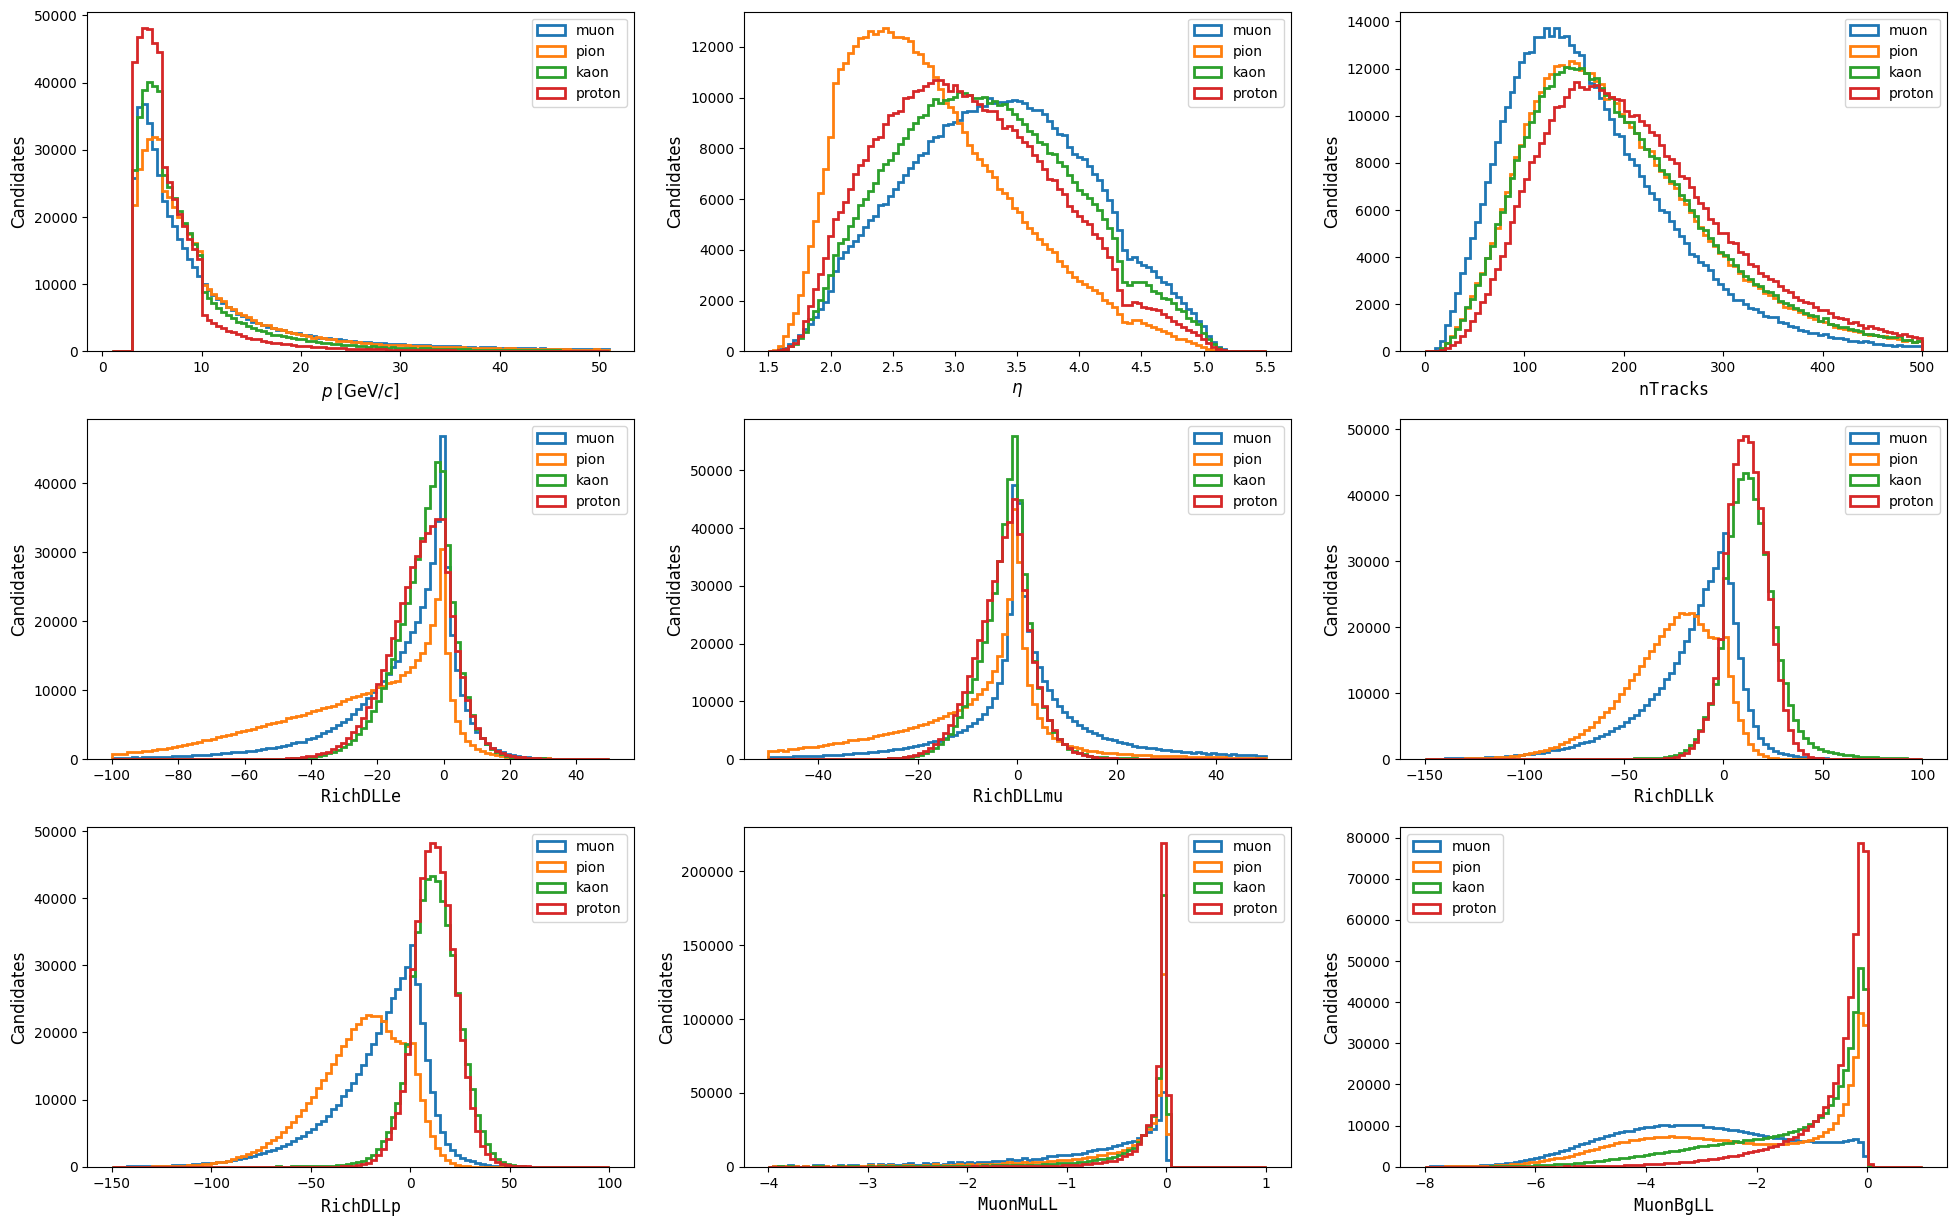

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 15), dpi=100)

plt.subplot(3, 3, 1)
plt.xlabel("$p$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["p_GeV"], bins=np.linspace(1.0, 51.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 3, 2)
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 3, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 3, 4)
plt.xlabel("$\mathtt{RichDLLe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["RichDLLe"], bins=np.linspace(-100.0, 50.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(3, 3, 5)
plt.xlabel("$\mathtt{RichDLLmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["RichDLLmu"], bins=np.linspace(-50.0, 50.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(3, 3, 6)
plt.xlabel("$\mathtt{RichDLLk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["RichDLLk"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 3, 7)
plt.xlabel("$\mathtt{RichDLLp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["RichDLLp"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 3, 8)
plt.xlabel("$\mathtt{MuonMuLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["MuonMuLL"], bins=np.linspace(-4.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(3, 3, 9)
plt.xlabel("$\mathtt{MuonBgLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["MuonBgLL"], bins=np.linspace(-8.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.show()

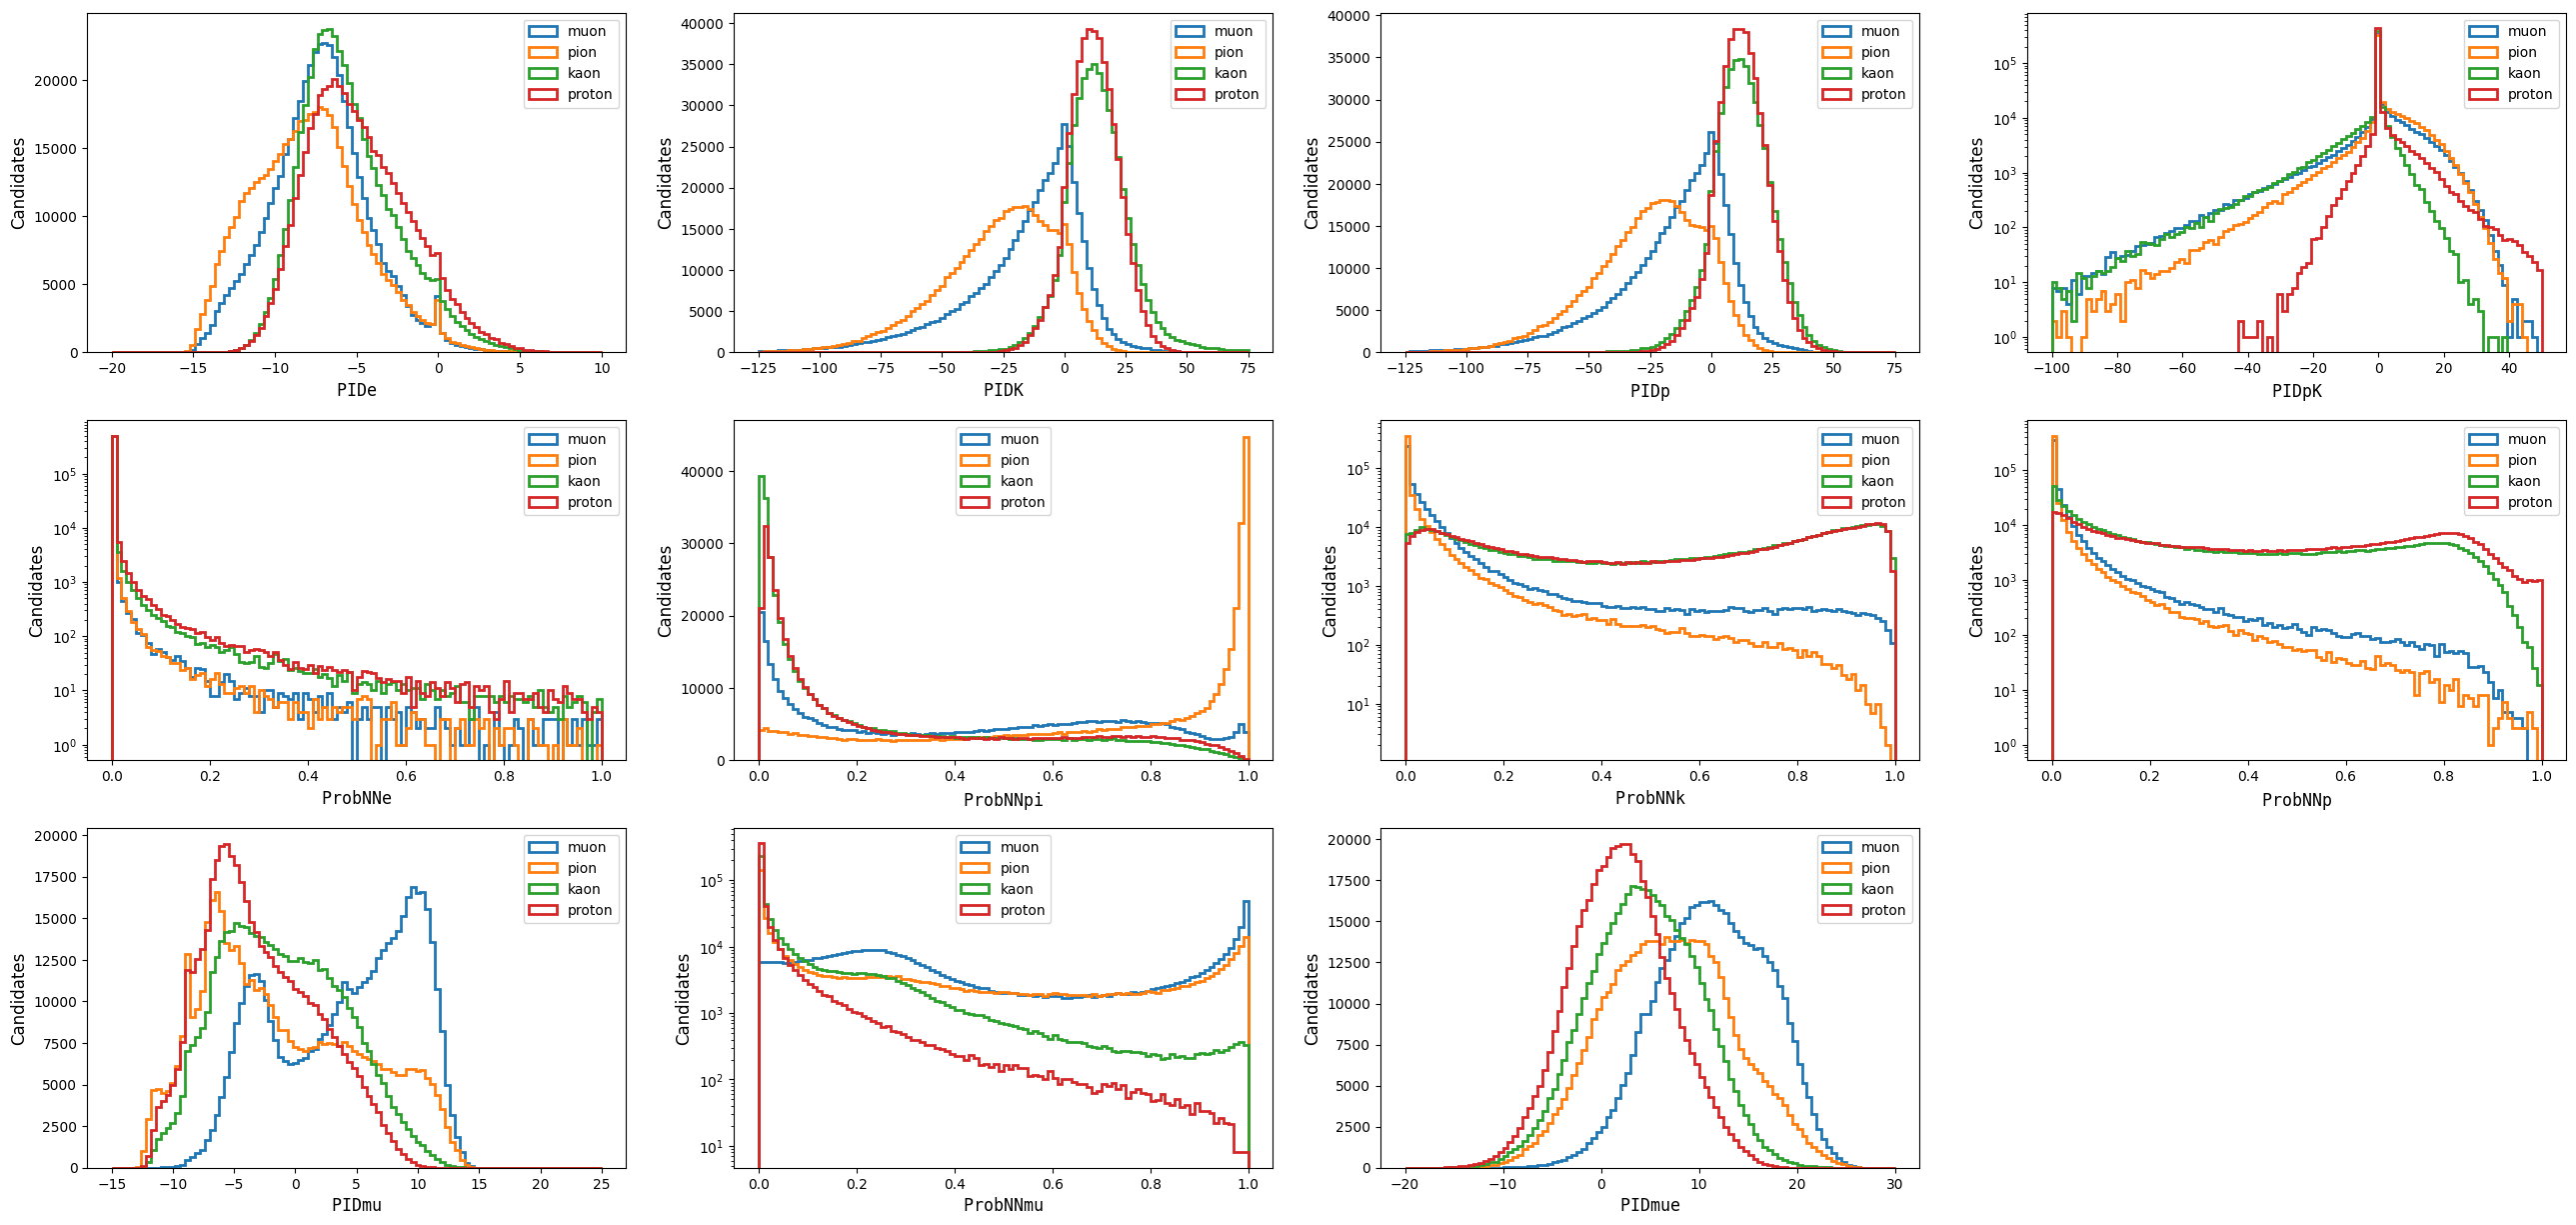

In [13]:
plt.figure(figsize=(32, 15), dpi=100)

plt.subplot(3, 4, 1)
plt.xlabel("$\mathtt{PIDe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDe"], bins=np.linspace(-20.0, 10.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 2)
plt.xlabel("$\mathtt{PIDK}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDK"], bins=np.linspace(-125.0, 75.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 3)
plt.xlabel("$\mathtt{PIDp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDp"], bins=np.linspace(-125.0, 75.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 4)
plt.xlabel("$\mathtt{PIDpK}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDp"] - dfs_im[part]["PIDK"], bins=np.linspace(-100.0, 50.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 5)
plt.xlabel("$\mathtt{ProbNNe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["ProbNNe"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 6)
plt.xlabel("$\mathtt{ProbNNpi}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["ProbNNpi"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 7)
plt.xlabel("$\mathtt{ProbNNk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["ProbNNk"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 8)
plt.xlabel("$\mathtt{ProbNNp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["ProbNNp"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 9)
plt.xlabel("$\mathtt{PIDmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDmu"], bins=np.linspace(-15.0, 25.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 10)
plt.xlabel("$\mathtt{ProbNNmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["ProbNNmu"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 11)
plt.xlabel("$\mathtt{PIDmue}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_im[part]["PIDmu"] - dfs_im[part]["PIDe"], bins=np.linspace(-20.0, 30.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.show()

### Preprocessing

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler

n_features = len(real_conditions_im)
n_flags = len(flag_conditions_im)
n_target = len(target_im)

prep_step_x_im = dict()
for part in particles:
    prep_step_x_im[part] = ColumnTransformer(
        [
            ('quantile', QuantileTransformer(output_distribution='normal'), np.arange(n_features - 2)),
            ('standard', StandardScaler(), n_features - 2 + np.arange(2)),
            ('flags', "passthrough", n_features + np.arange(n_flags)),
        ]
    ).fit(dfs_im[part][conditions_im].values)

prep_step_y_im = dict()
for part in particles:
    prep_step_y_im[part] = ColumnTransformer(
        [
            ('standard', StandardScaler(), [0, 1, 2, 7]),
            ('probs', MinMaxScaler(feature_range=(-1.0, 1.0)), [3, 4, 5, 6, 8]),
        ]
    ).fit(dfs_im[part][target_im].values)

In [15]:
from preprocessing_utils import store_as_pickle

for part in particles:
    display(
        store_as_pickle(
            prep_step_x_im[part],
            f"GLOBALPID_IM_{part.upper()}_PREPROCESSING_X",
            f"/home/mabarbet/PythonFastSim/models/GlobalPID-im_{part}_models/tX_{SAMPLE}.pkl",
        )
    )
    display(
        store_as_pickle(
            prep_step_y_im[part],
            f"GLOBALPID_IM_{part.upper()}_PREPROCESSING_Y",
            f"/home/mabarbet/PythonFastSim/models/GlobalPID-im_{part}_models/tY_{SAMPLE}.pkl",
        )
    )

2024-01-08 01:53:38.342547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 01:53:38.342612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 01:53:38.342660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 01:53:38.354687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [16]:
DATA_PATH = "/home/mabarbet/PythonFastSim/data" if LOCAL else "/workarea/cloud-storage/mabarbet/data"

#### Muons

In [17]:
from preprocessing_utils import split_and_store

entries = split_and_store(
    sim_im["muon"][conditions_im + target_im],
    [
        (0.5, environ.get("GLOBALPID_IM_MUON_TRAIN", f"{DATA_PATH}/GlobalPID-im-muon-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_IM_MUON_TEST", f"{DATA_PATH}/GlobalPID-im-muon-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_IM_MUON_VALIDATION", f"{DATA_PATH}/GlobalPID-im-muon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_im,
    labels=target_im,
    preprocessorX=prep_step_x_im["muon"],
    preprocessorY=prep_step_y_im["muon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-muon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-muon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-muon-2016MU-validation


,0
Train,11632286
Test,9309429
Validation,2325692


In [18]:
from feather_io import FeatherReader    

reader_train =  FeatherReader(environ.get("GLOBALPID_IM_MUON_TRAIN", f"{DATA_PATH}/GlobalPID-im-muon-{SAMPLE}-train"), max_files=3)
ds_train_mu = reader_train.as_tf_dataset()

In [19]:
X_mu, y_mu = next(iter(ds_train_mu.batch(2_000_000)))
X_mu.shape, y_mu.shape

(TensorShape([2000000, 10]), TensorShape([2000000, 9]))

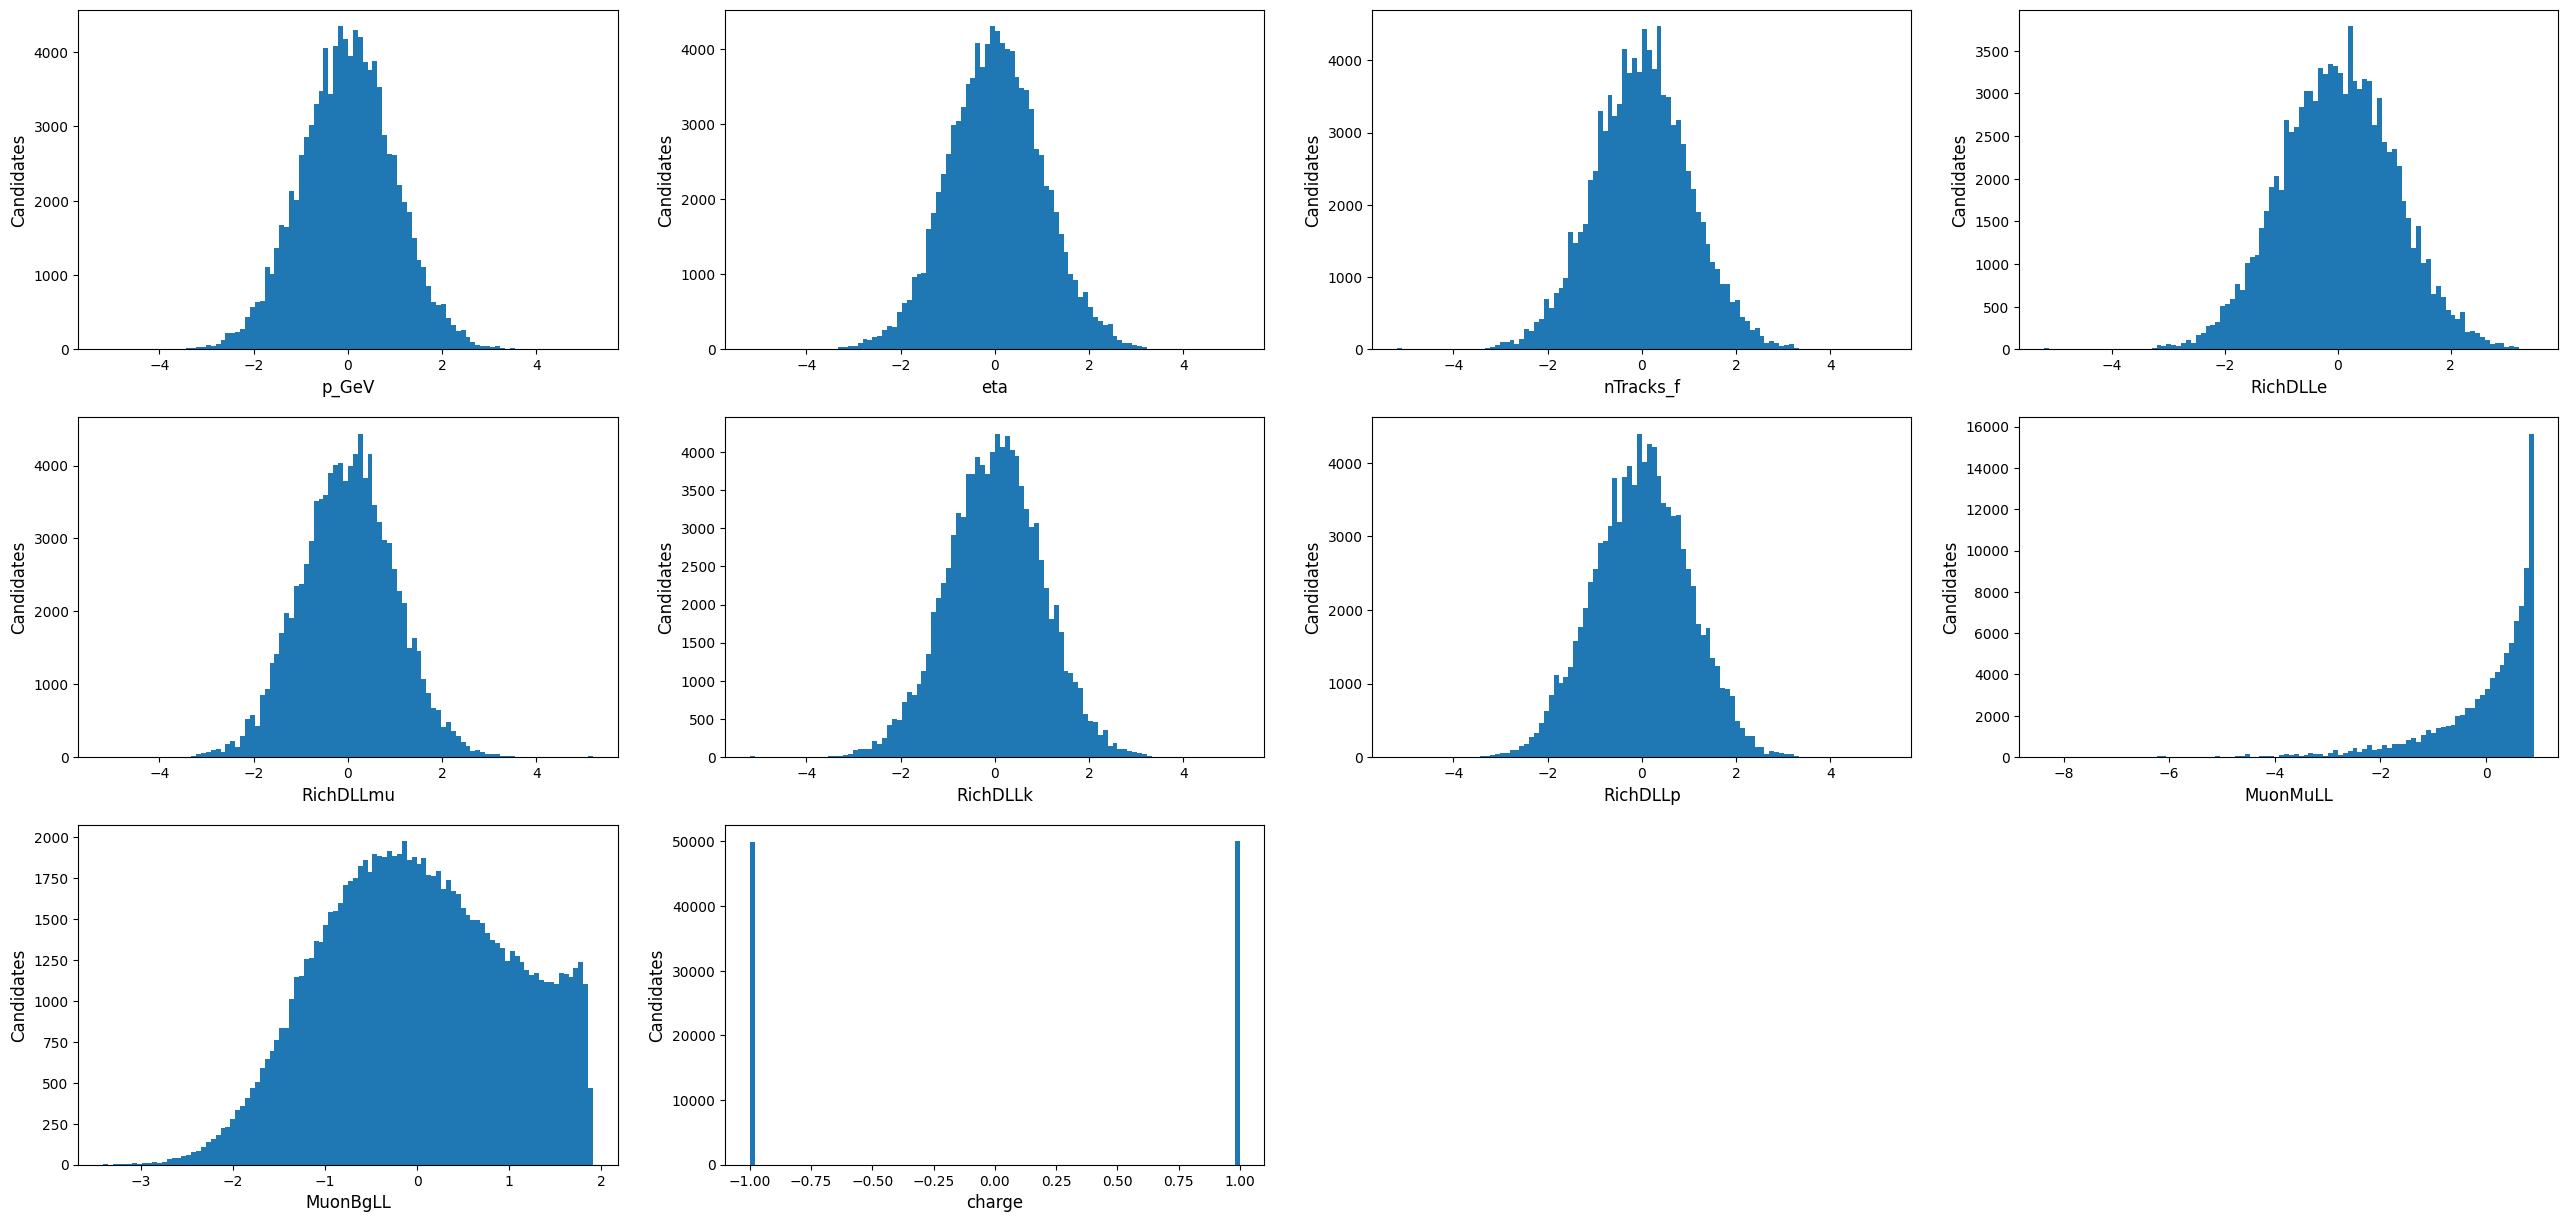

In [20]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_mu[:, i].numpy()[:100000], bins=100)

plt.show()

In [21]:
reord_target_im = ["PIDe", "PIDK", "PIDp", "PIDmu", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp", "ProbNNmu"]

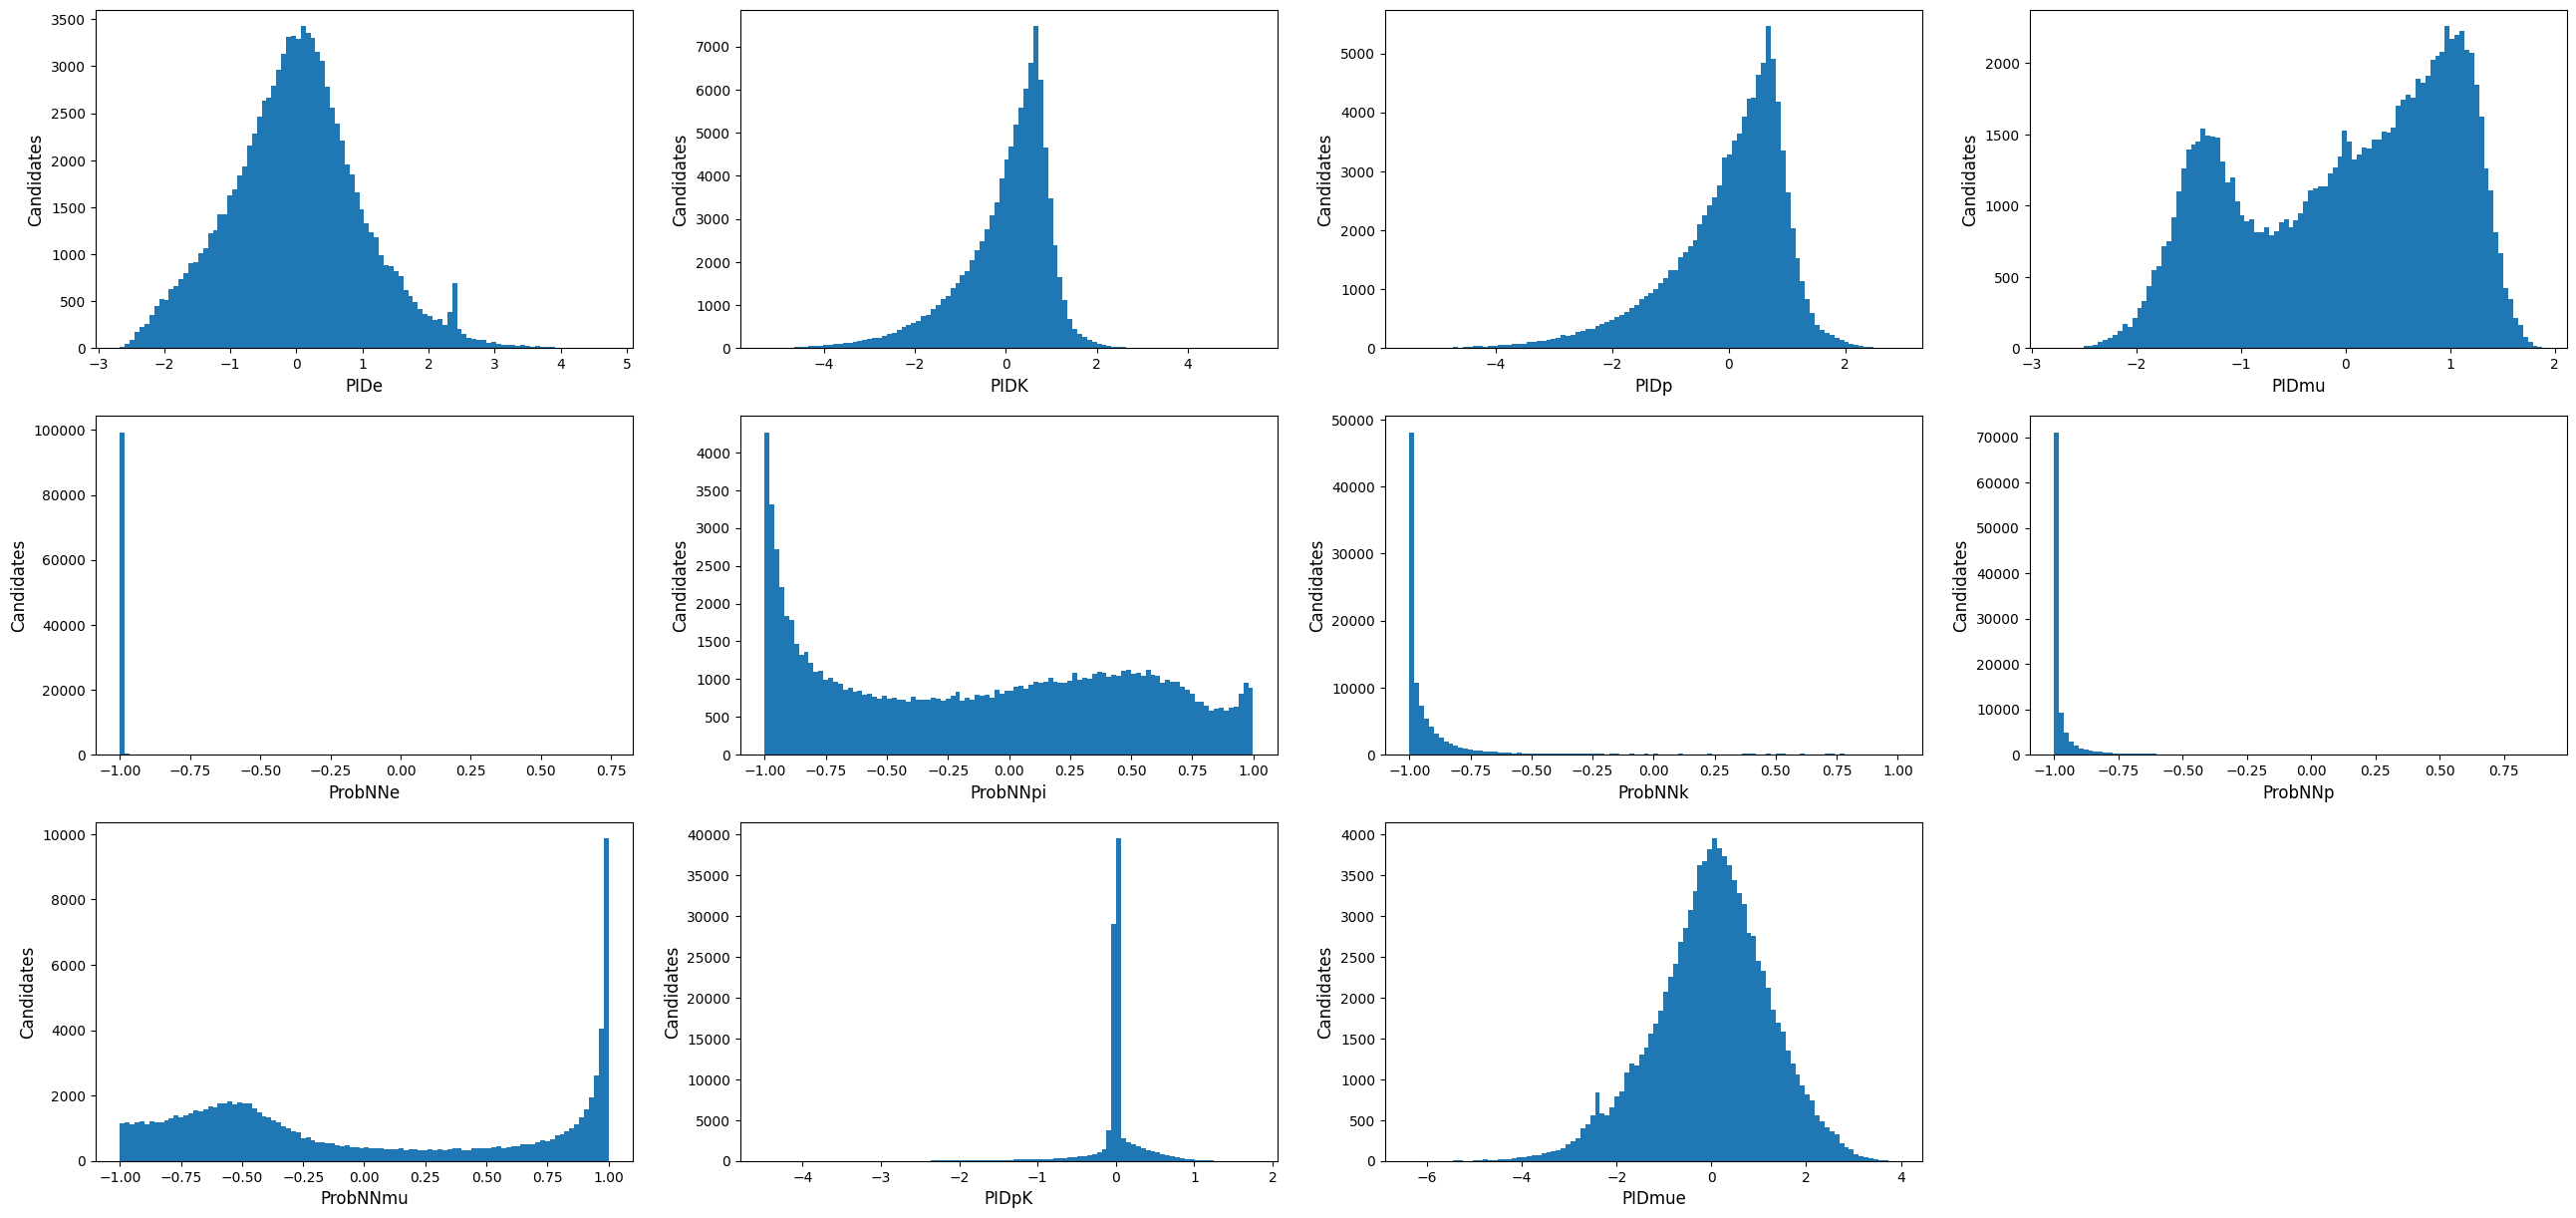

In [22]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_mu[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_mu[:, 2].numpy()[:100000] - y_mu[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 11)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_mu[:, 3].numpy()[:100000] - y_mu[:, 0].numpy()[:100000], bins=100)

plt.show()

In [23]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-im-muon-{SAMPLE}-trainset.npz",
    x=X_mu.numpy(),
    x_vars=conditions_im,
    y=y_mu.numpy(),
    y_vars=target_im,
    w=None,
    w_var=None,
)

#### Pions

In [24]:
entries = split_and_store(
    sim_im["pion"][conditions_im + target_im],
    [
        (0.5, environ.get("GLOBALPID_IM_PION_TRAIN", f"{DATA_PATH}/GlobalPID-im-pion-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_IM_PION_TEST", f"{DATA_PATH}/GlobalPID-im-pion-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_IM_PION_VALIDATION", f"{DATA_PATH}/GlobalPID-im-pion-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_im,
    labels=target_im,
    preprocessorX=prep_step_x_im["pion"],
    preprocessorY=prep_step_y_im["pion"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-pion-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-pion-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-pion-2016MU-validation


,0
Train,1300609
Test,1041582
Validation,259685


In [25]:
reader_train =  FeatherReader(environ.get("GLOBALPID_IM_PION_TRAIN", f"{DATA_PATH}/GlobalPID-im-pion-{SAMPLE}-train"), max_files=3)
ds_train_pi = reader_train.as_tf_dataset()

In [26]:
X_pi, y_pi = next(iter(ds_train_pi.batch(2_000_000)))
X_pi.shape, y_pi.shape

(TensorShape([1300611, 10]), TensorShape([1300611, 9]))

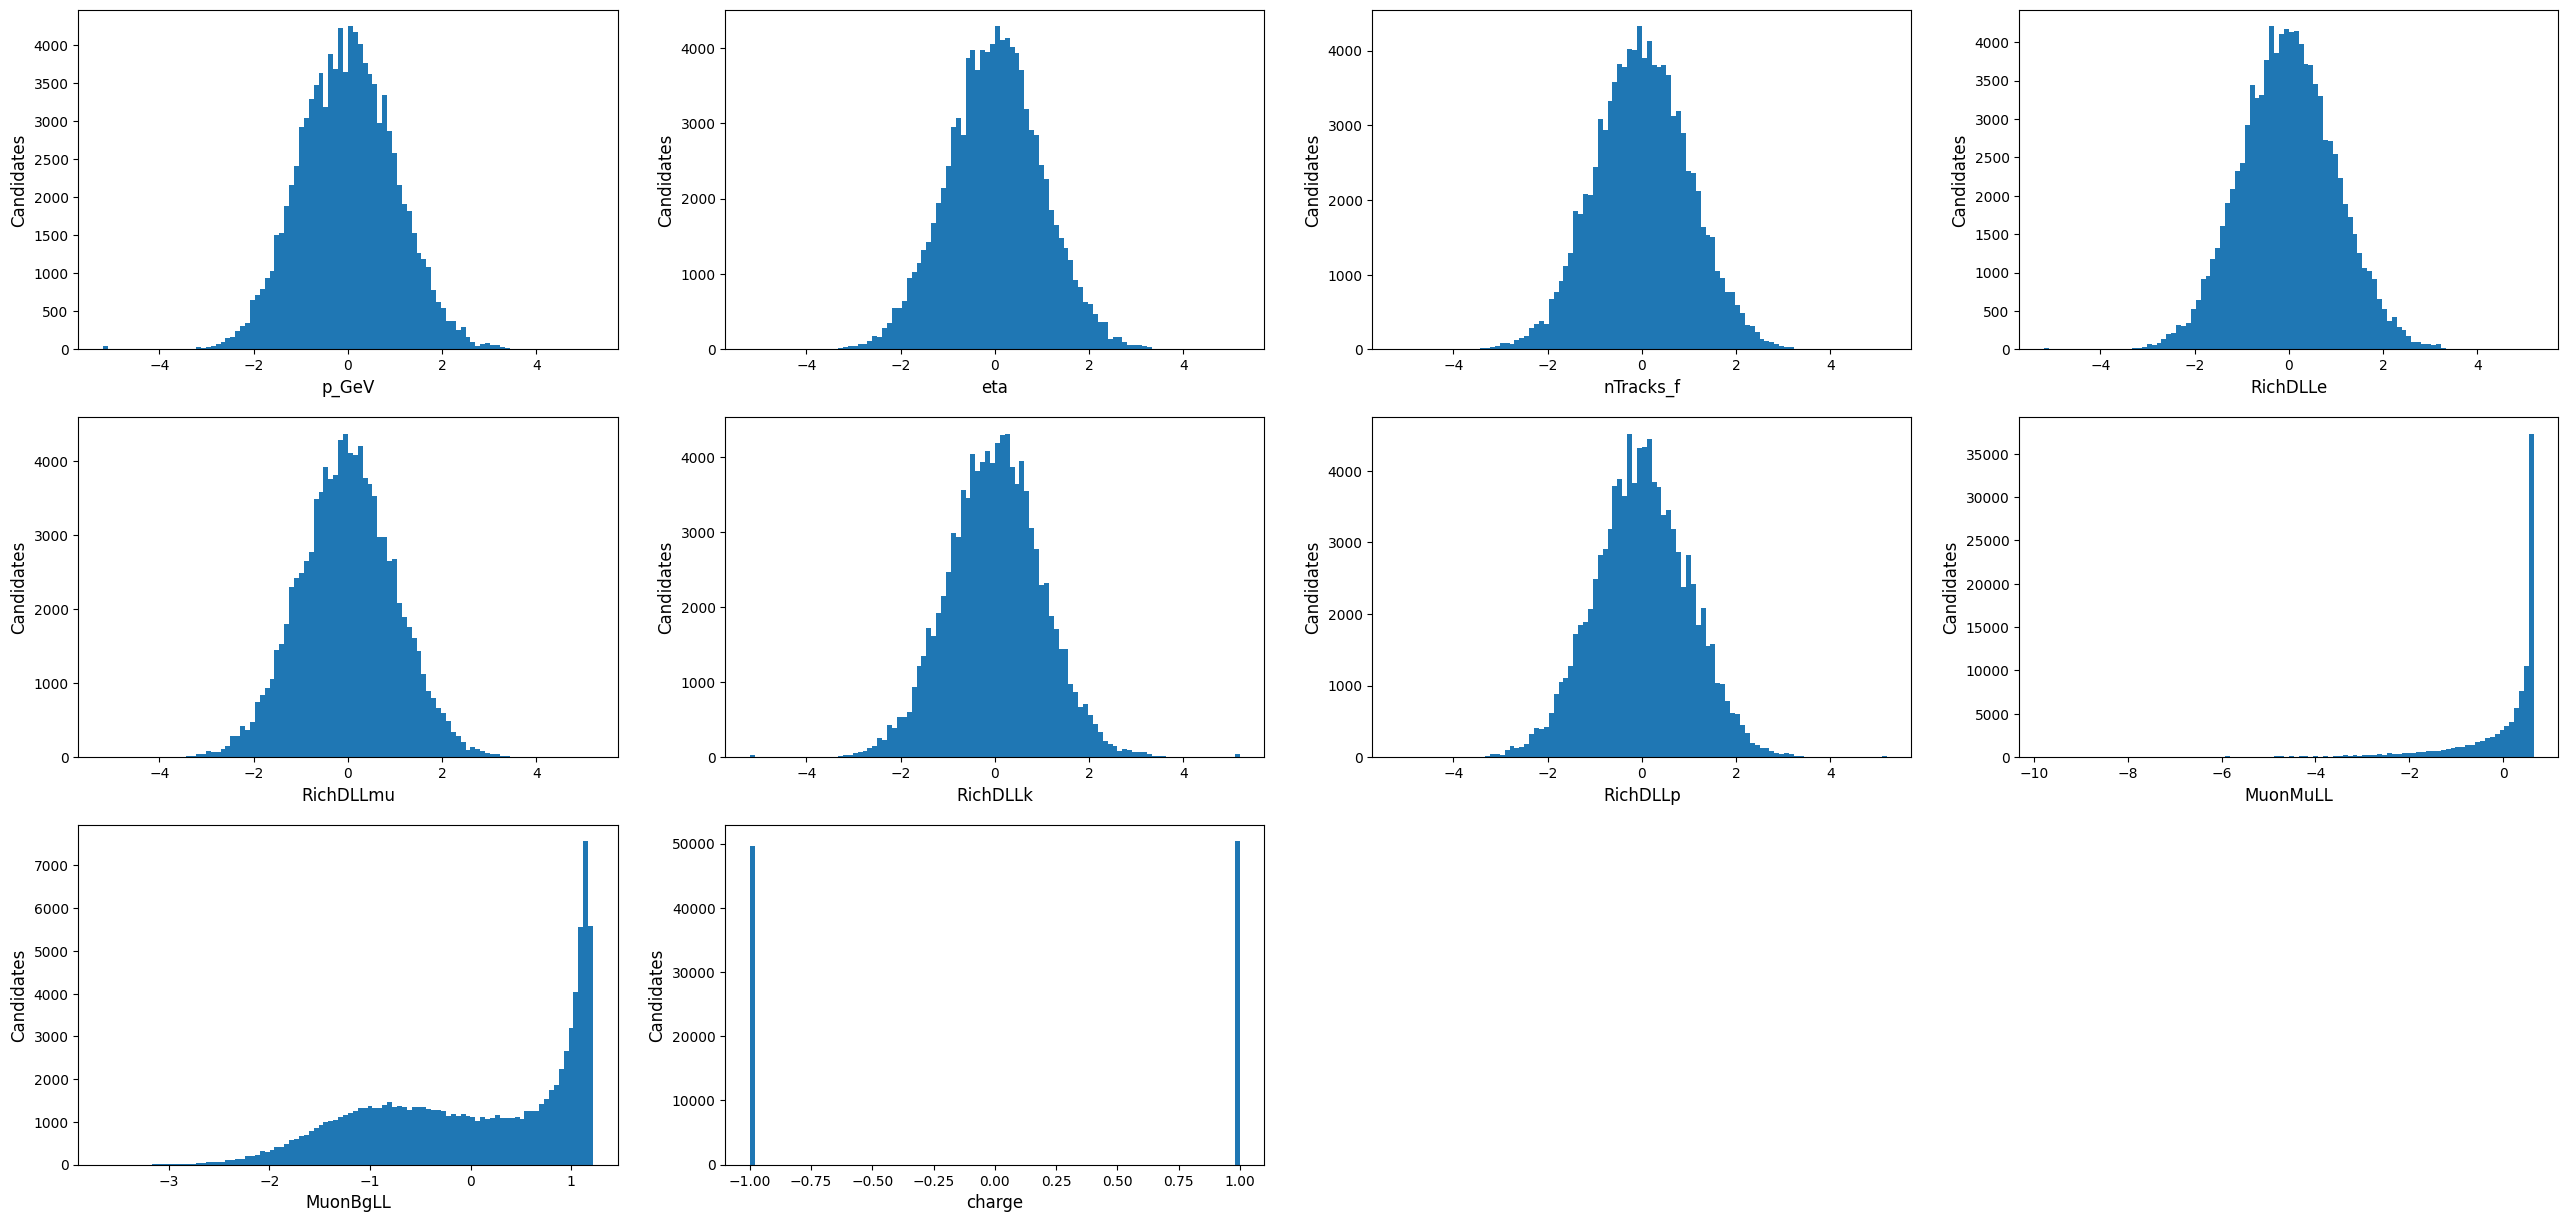

In [27]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_pi[:, i].numpy()[:100000], bins=100)

plt.show()

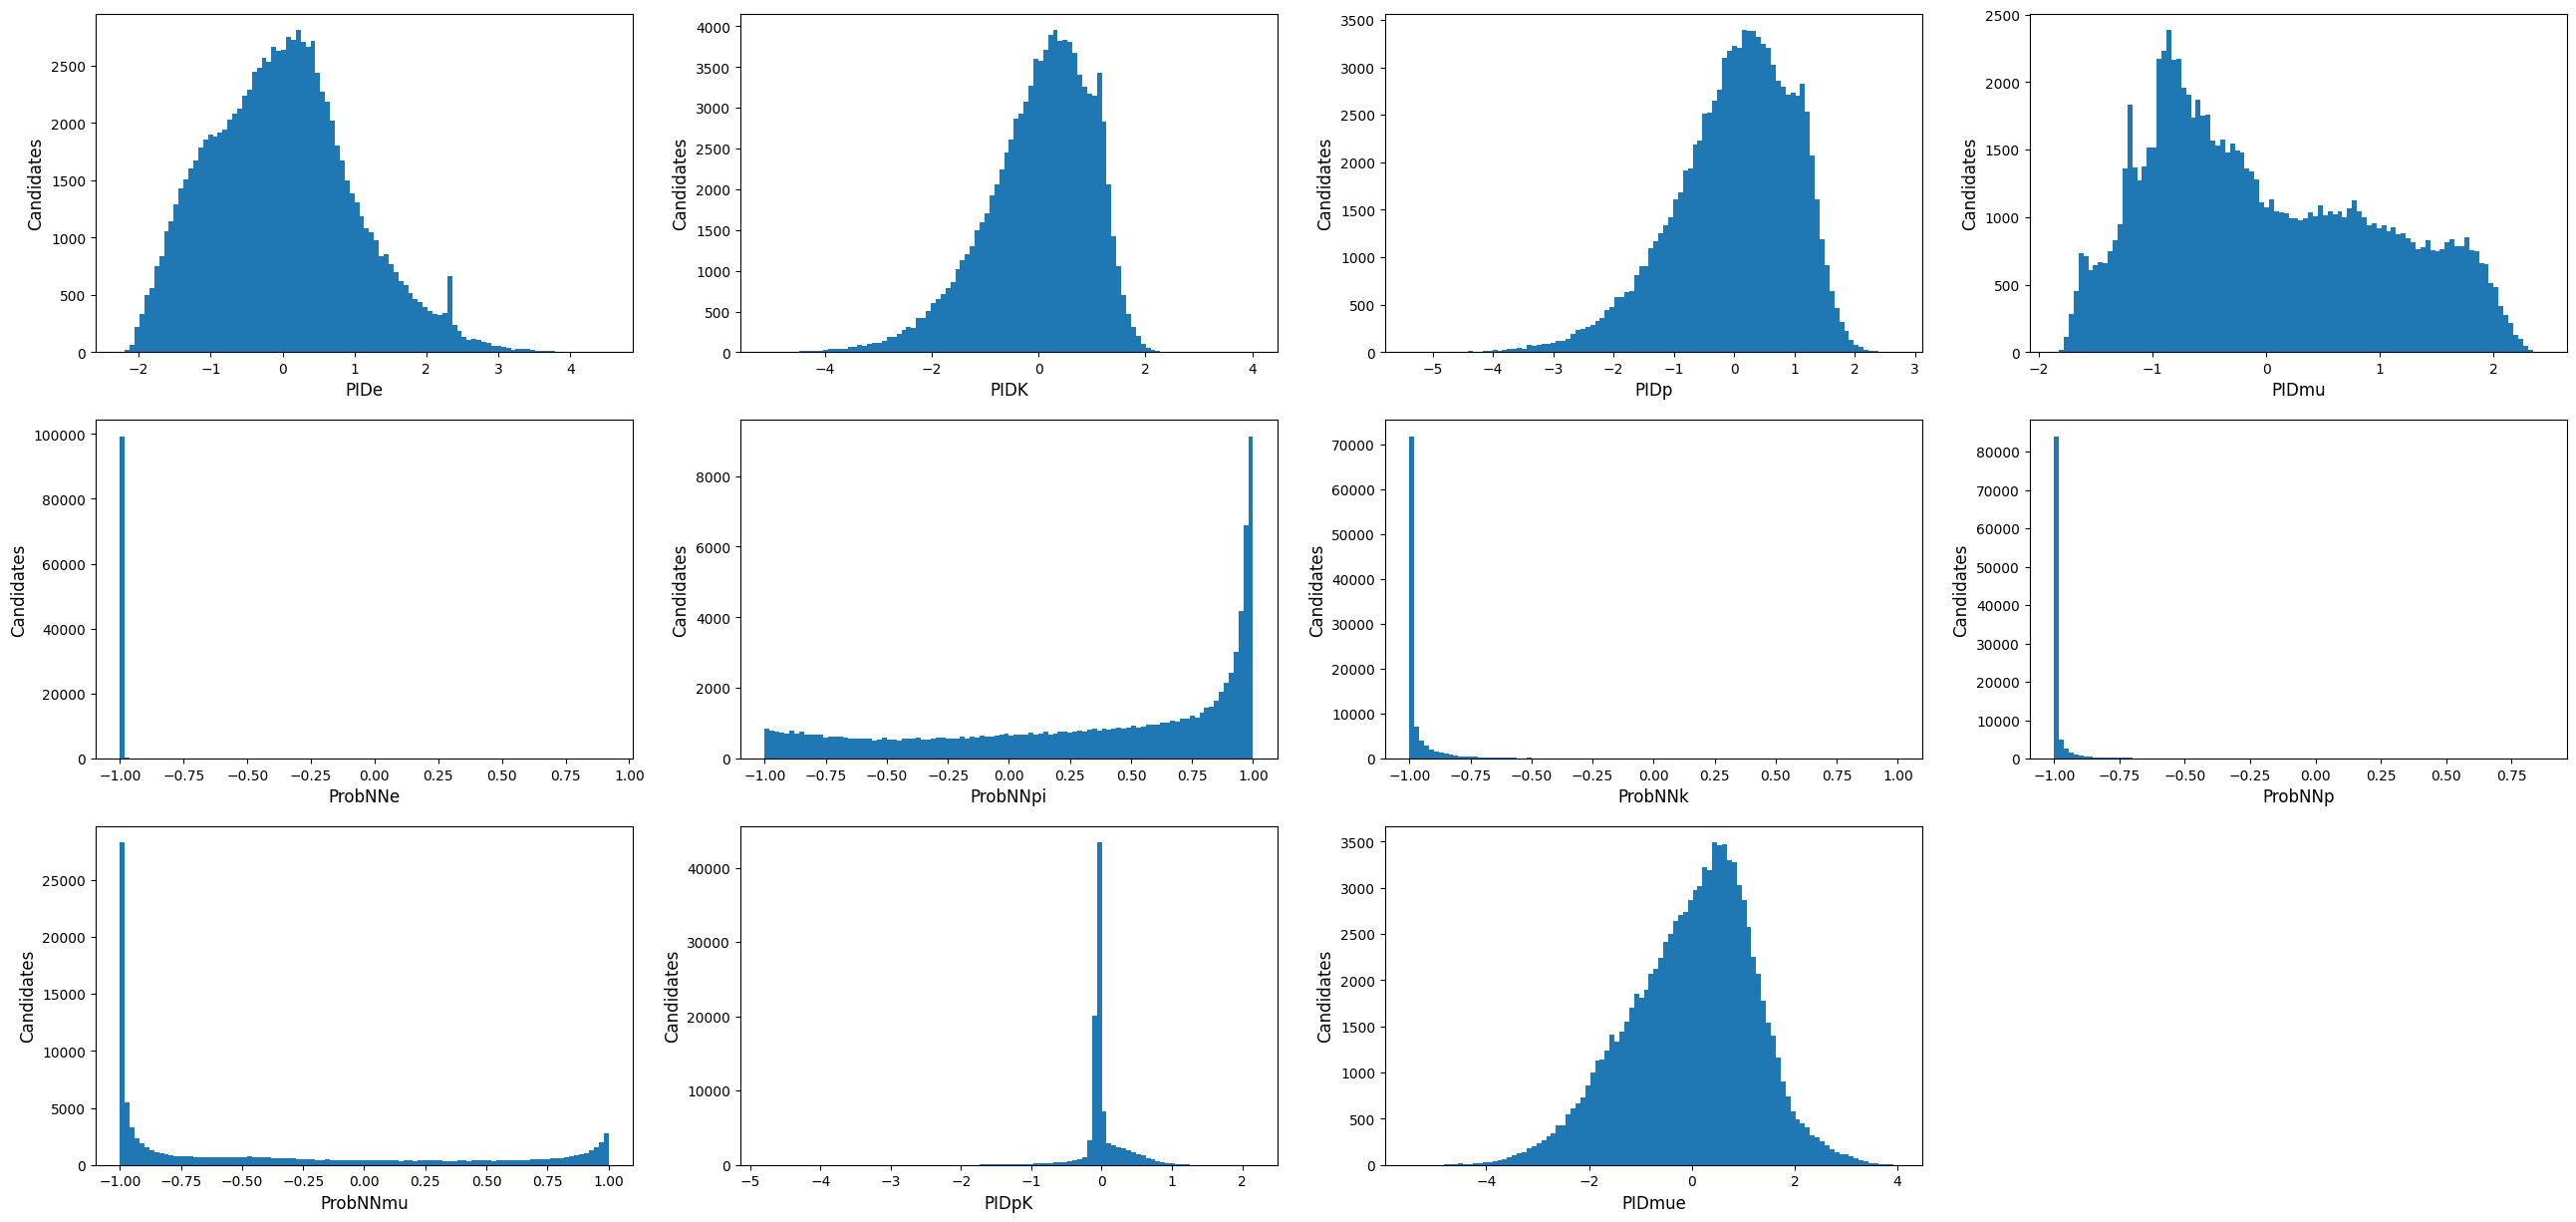

In [28]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_pi[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_pi[:, 2].numpy()[:100000] - y_pi[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 11)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_pi[:, 3].numpy()[:100000] - y_pi[:, 0].numpy()[:100000], bins=100)

plt.show()

In [29]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-im-pion-{SAMPLE}-trainset.npz",
    x=X_pi.numpy(),
    x_vars=conditions_im,
    y=y_pi.numpy(),
    y_vars=target_im,
    w=None,
    w_var=None,
)

#### Kaons

In [30]:
entries = split_and_store(
    sim_im["kaon"][conditions_im + target_im],
    [
        (0.5, environ.get("GLOBALPID_IM_KAON_TRAIN", f"{DATA_PATH}/GlobalPID-im-kaon-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_IM_KAON_TEST", f"{DATA_PATH}/GlobalPID-im-kaon-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_IM_KAON_VALIDATION", f"{DATA_PATH}/GlobalPID-im-kaon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_im,
    labels=target_im,
    preprocessorX=prep_step_x_im["kaon"],
    preprocessorY=prep_step_y_im["kaon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-kaon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-kaon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-kaon-2016MU-validation


,0
Train,3811541
Test,3052414
Validation,764133


In [31]:
reader_train =  FeatherReader(environ.get("GLOBALPID_IM_KAON_TRAIN", f"{DATA_PATH}/GlobalPID-im-kaon-{SAMPLE}-train"), max_files=3)
ds_train_k = reader_train.as_tf_dataset()

In [32]:
X_k, y_k = next(iter(ds_train_k.batch(2_000_000)))
X_k.shape, y_k.shape

(TensorShape([2000000, 10]), TensorShape([2000000, 9]))

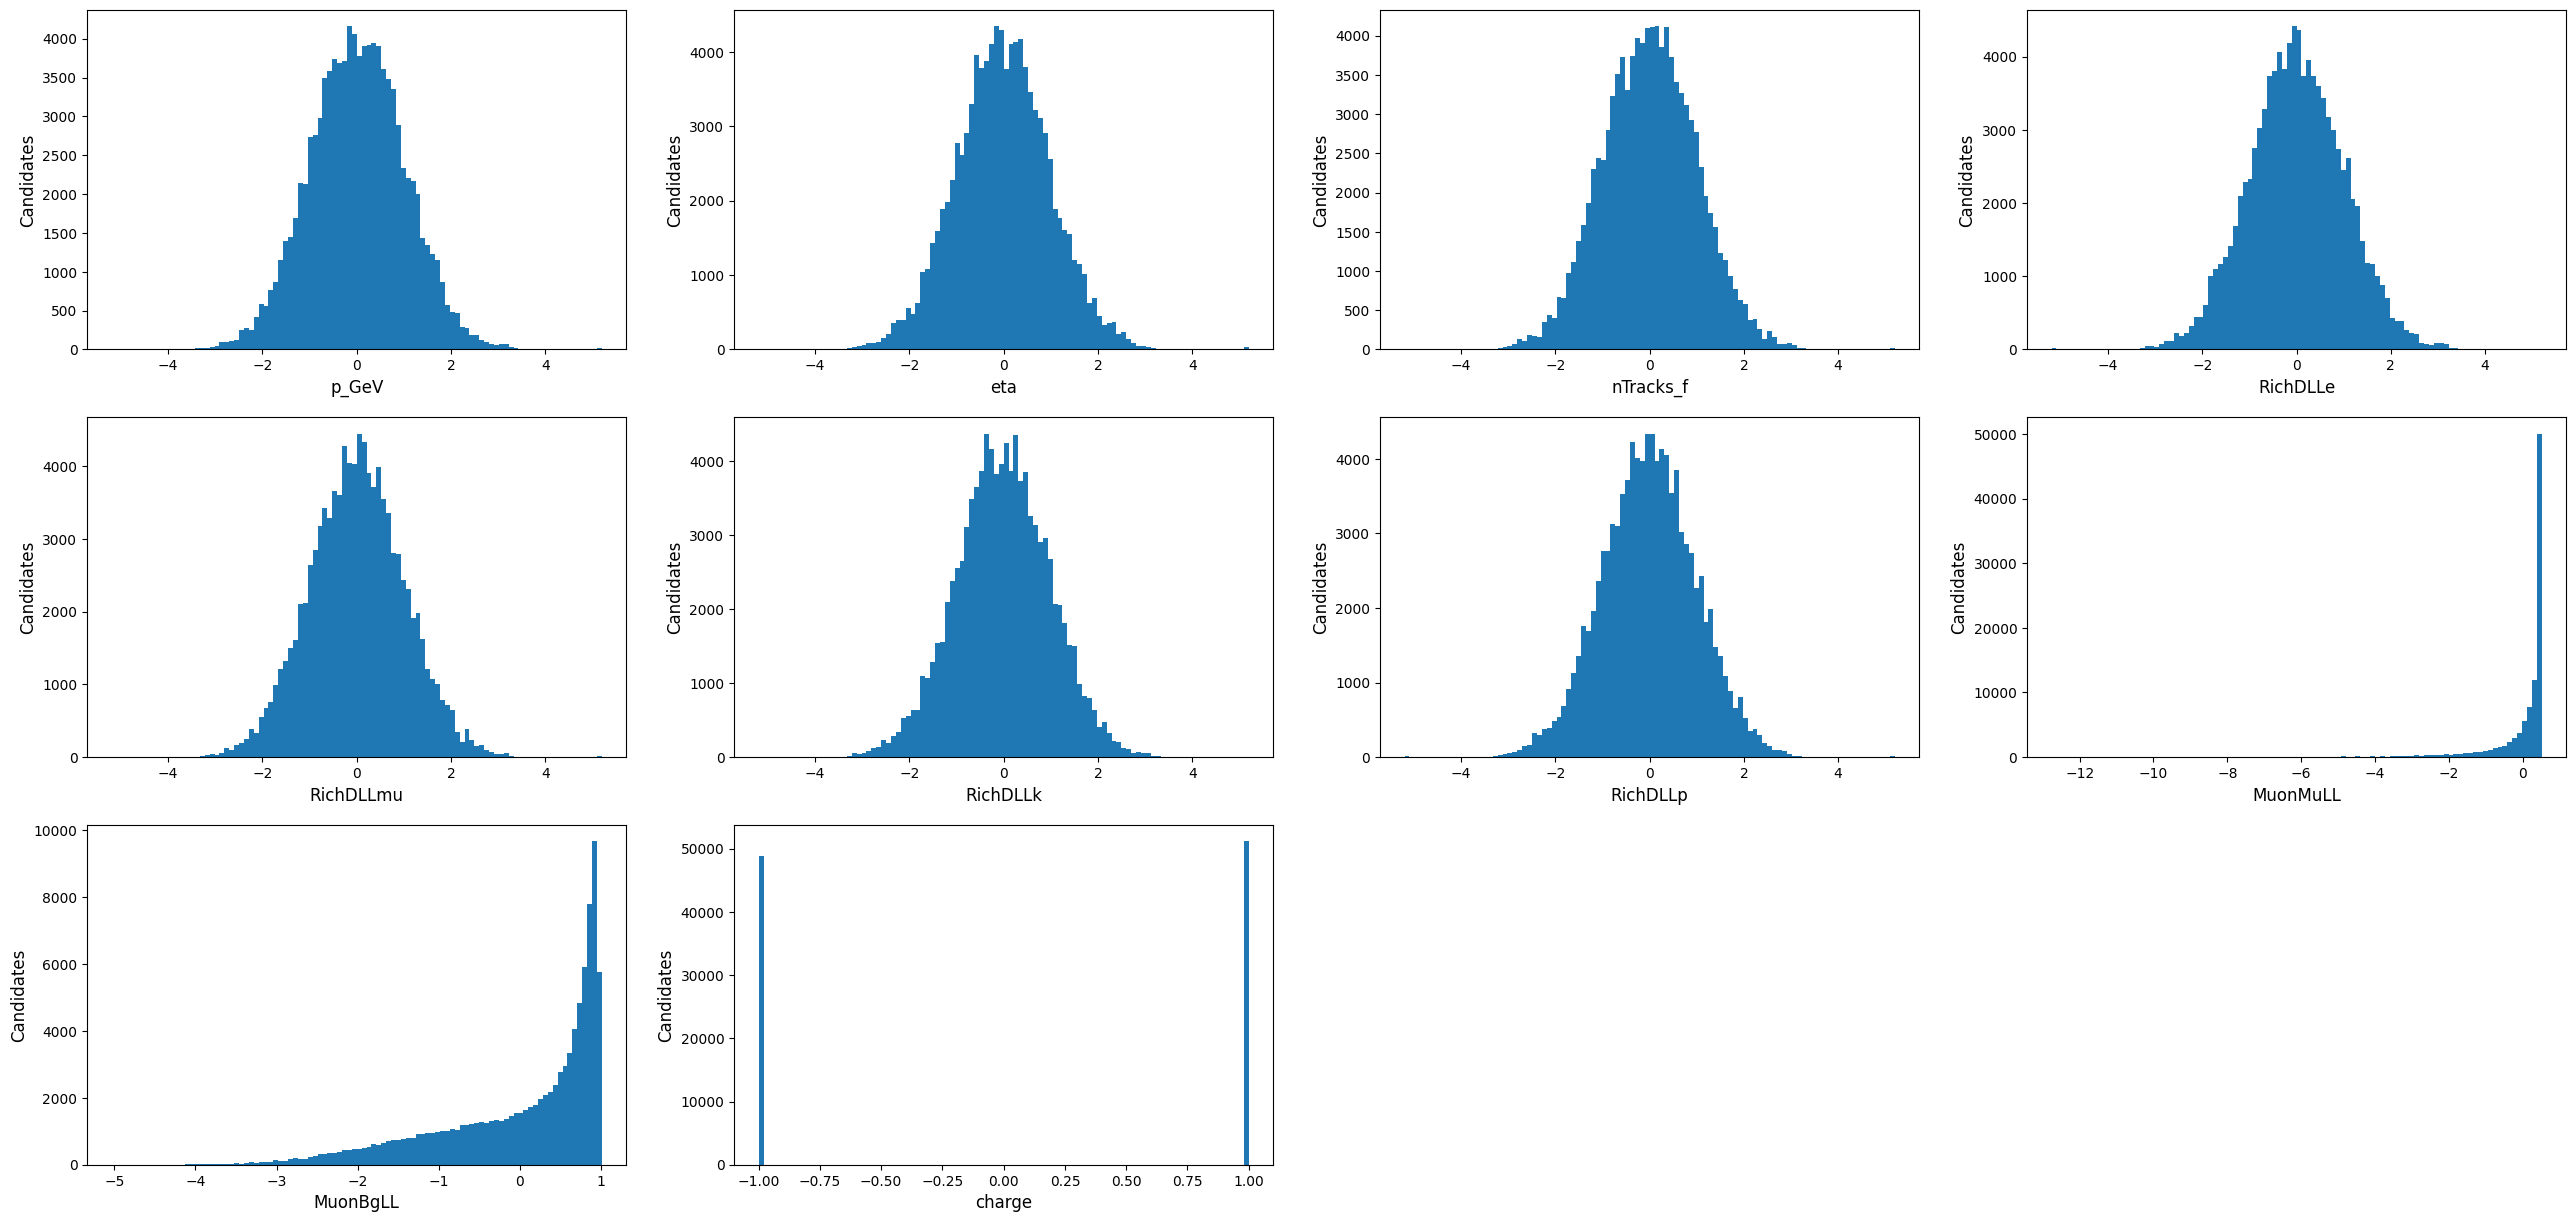

In [33]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_k[:, i].numpy()[:100000], bins=100)

plt.show()

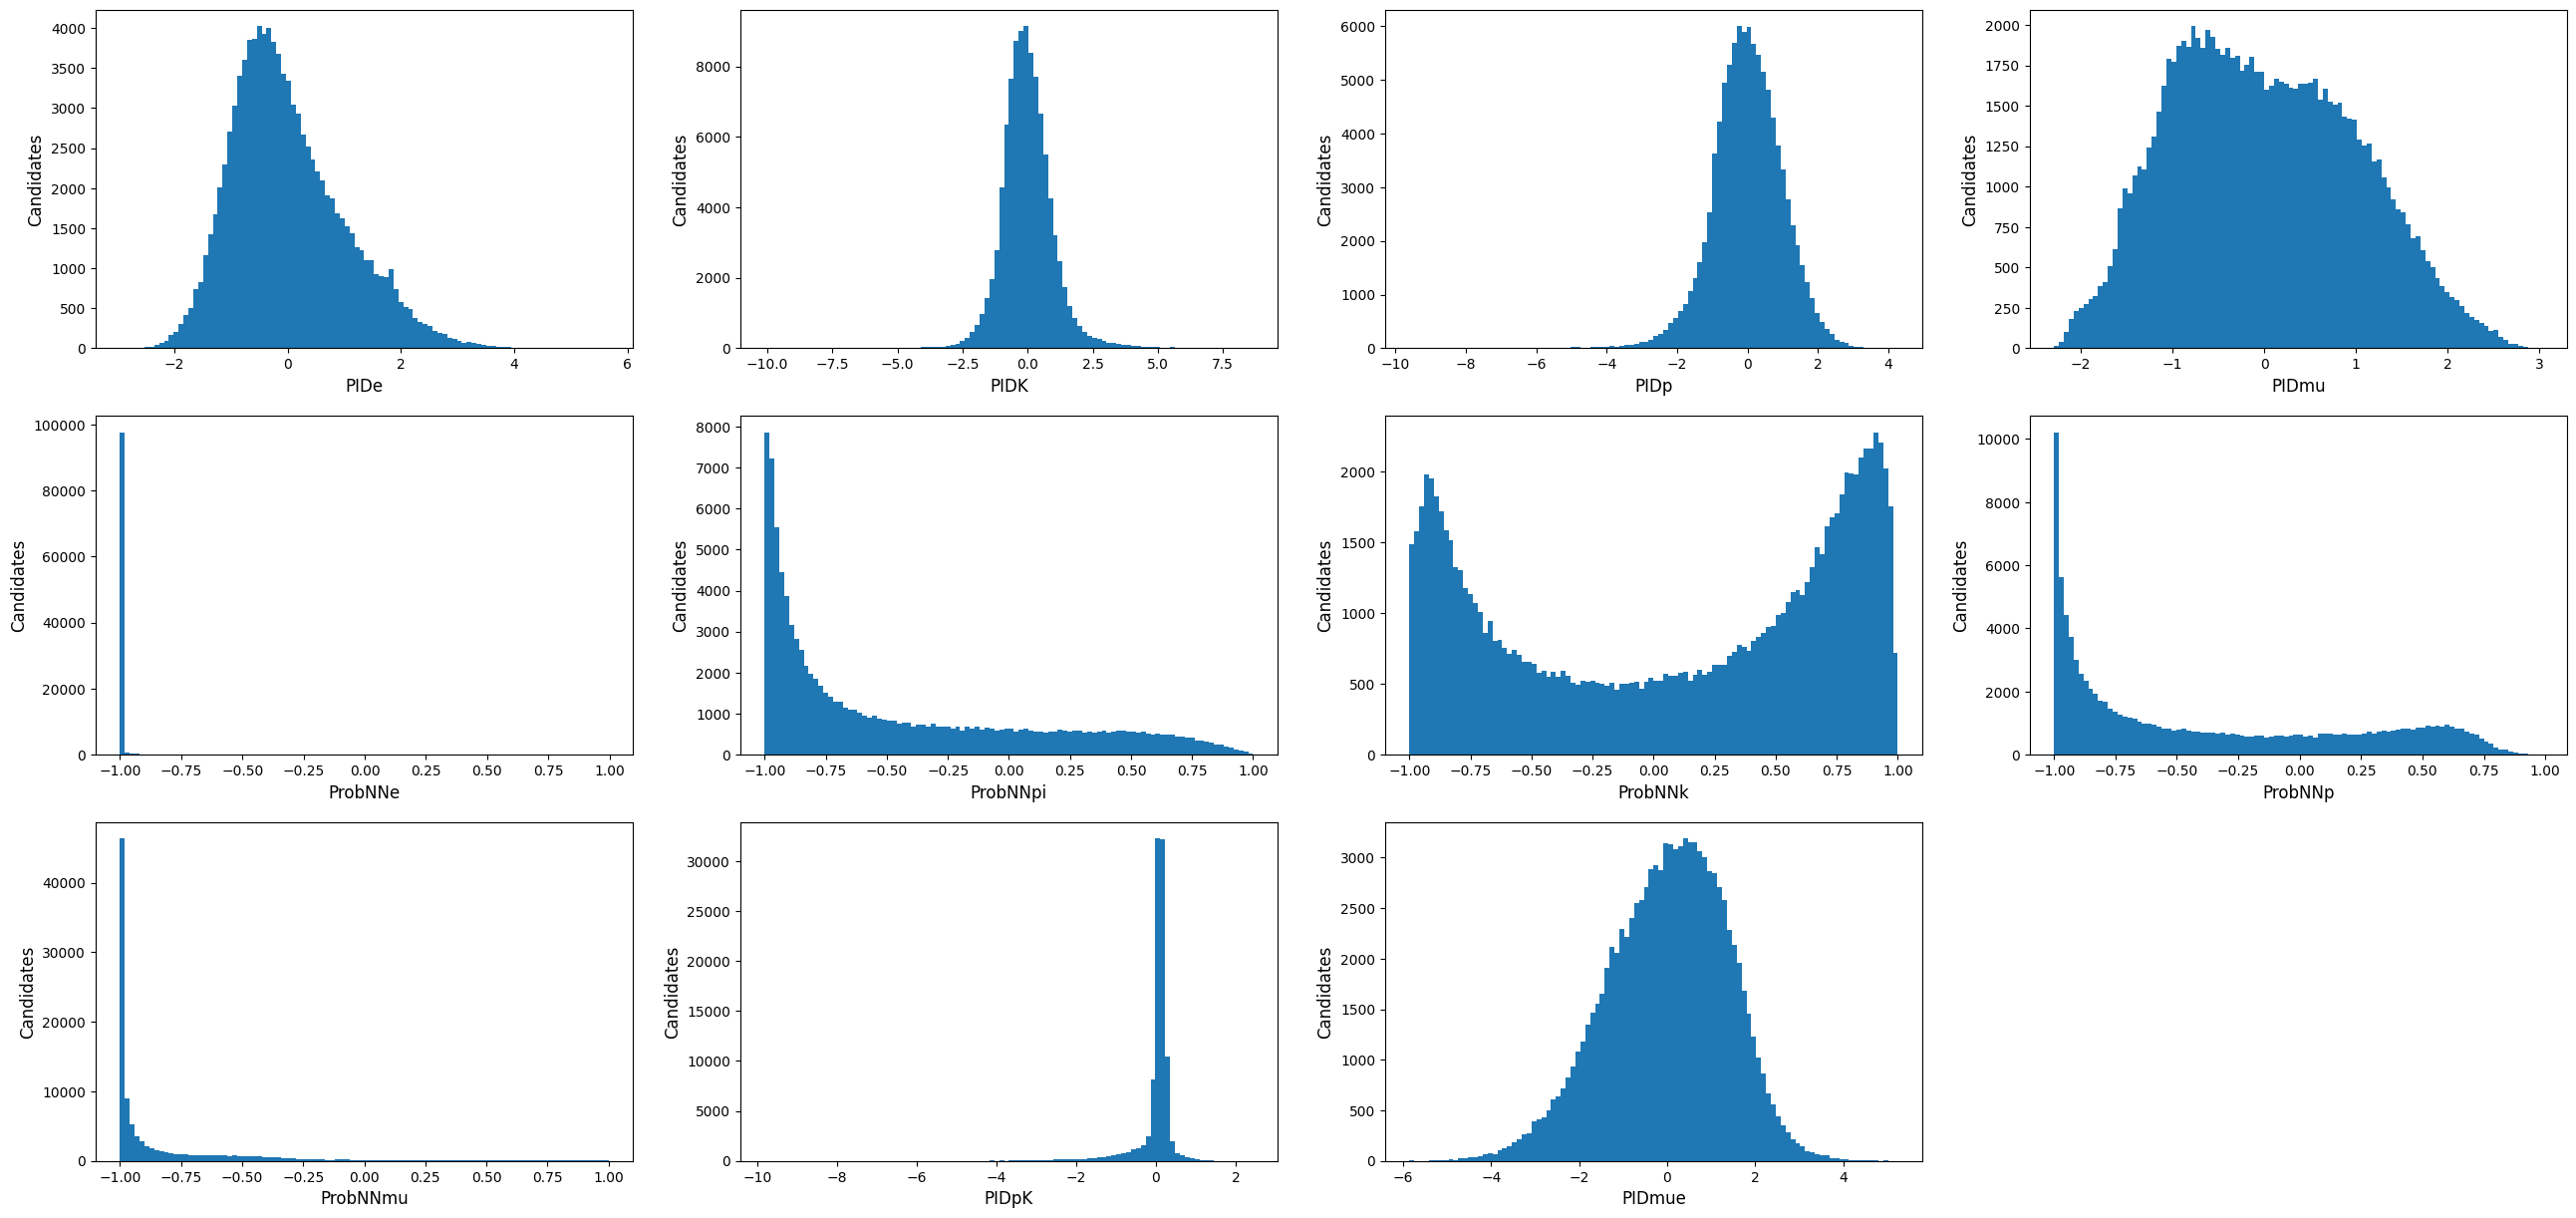

In [34]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_k[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_k[:, 2].numpy()[:100000] - y_k[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 11)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_k[:, 3].numpy()[:100000] - y_k[:, 0].numpy()[:100000], bins=100)

plt.show()

In [35]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-im-kaon-{SAMPLE}-trainset.npz",
    x=X_k.numpy(),
    x_vars=conditions_im,
    y=y_k.numpy(),
    y_vars=target_im,
    w=None,
    w_var=None,
)

#### Protons

In [36]:
entries = split_and_store(
    sim_im["proton"][conditions_im + target_im],
    [
        (0.5, environ.get("GLOBALPID_IM_PROTON_TRAIN", f"{DATA_PATH}/GlobalPID-im-proton-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_IM_PROTON_TEST", f"{DATA_PATH}/GlobalPID-im-proton-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_IM_PROTON_VALIDATION", f"{DATA_PATH}/GlobalPID-im-proton-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_im,
    labels=target_im,
    preprocessorX=prep_step_x_im["proton"],
    preprocessorY=prep_step_y_im["proton"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-proton-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-proton-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-im-proton-2016MU-validation


,0
Train,1517726
Test,1212800
Validation,303569


In [37]:
reader_train =  FeatherReader(environ.get("GLOBALPID_IM_PROTON_TRAIN", f"{DATA_PATH}/GlobalPID-im-proton-{SAMPLE}-train"), max_files=3)
ds_train_p = reader_train.as_tf_dataset()

In [38]:
X_p, y_p = next(iter(ds_train_p.batch(2_000_000)))
X_p.shape, y_p.shape

(TensorShape([1517728, 10]), TensorShape([1517728, 9]))

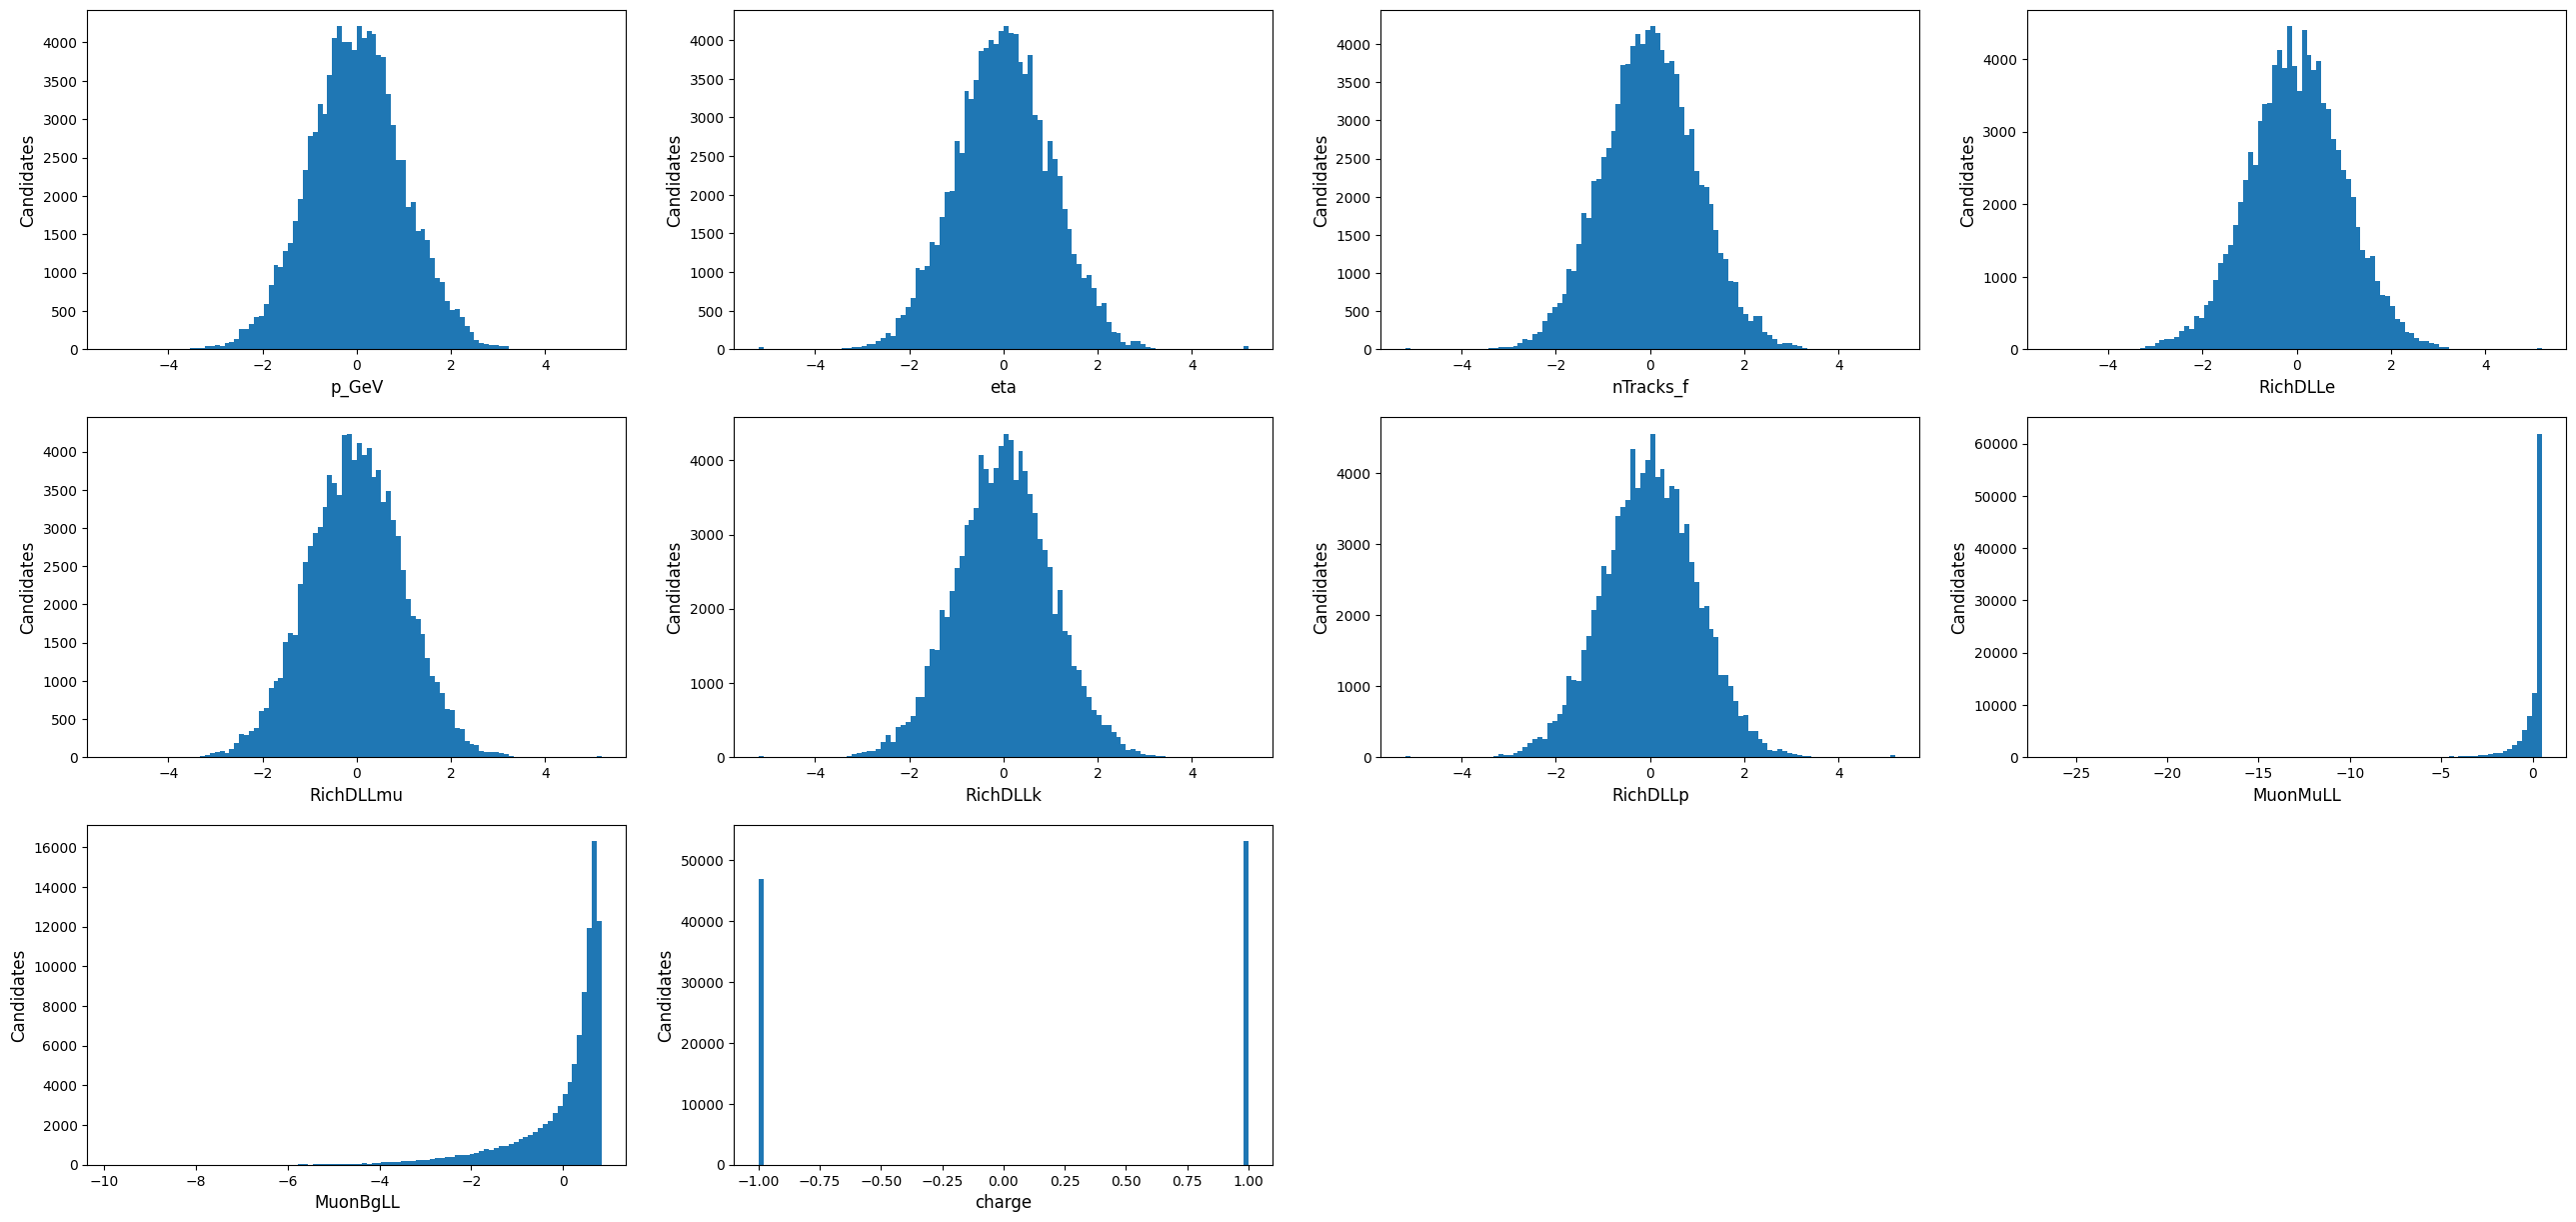

In [39]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_p[:, i].numpy()[:100000], bins=100)

plt.show()

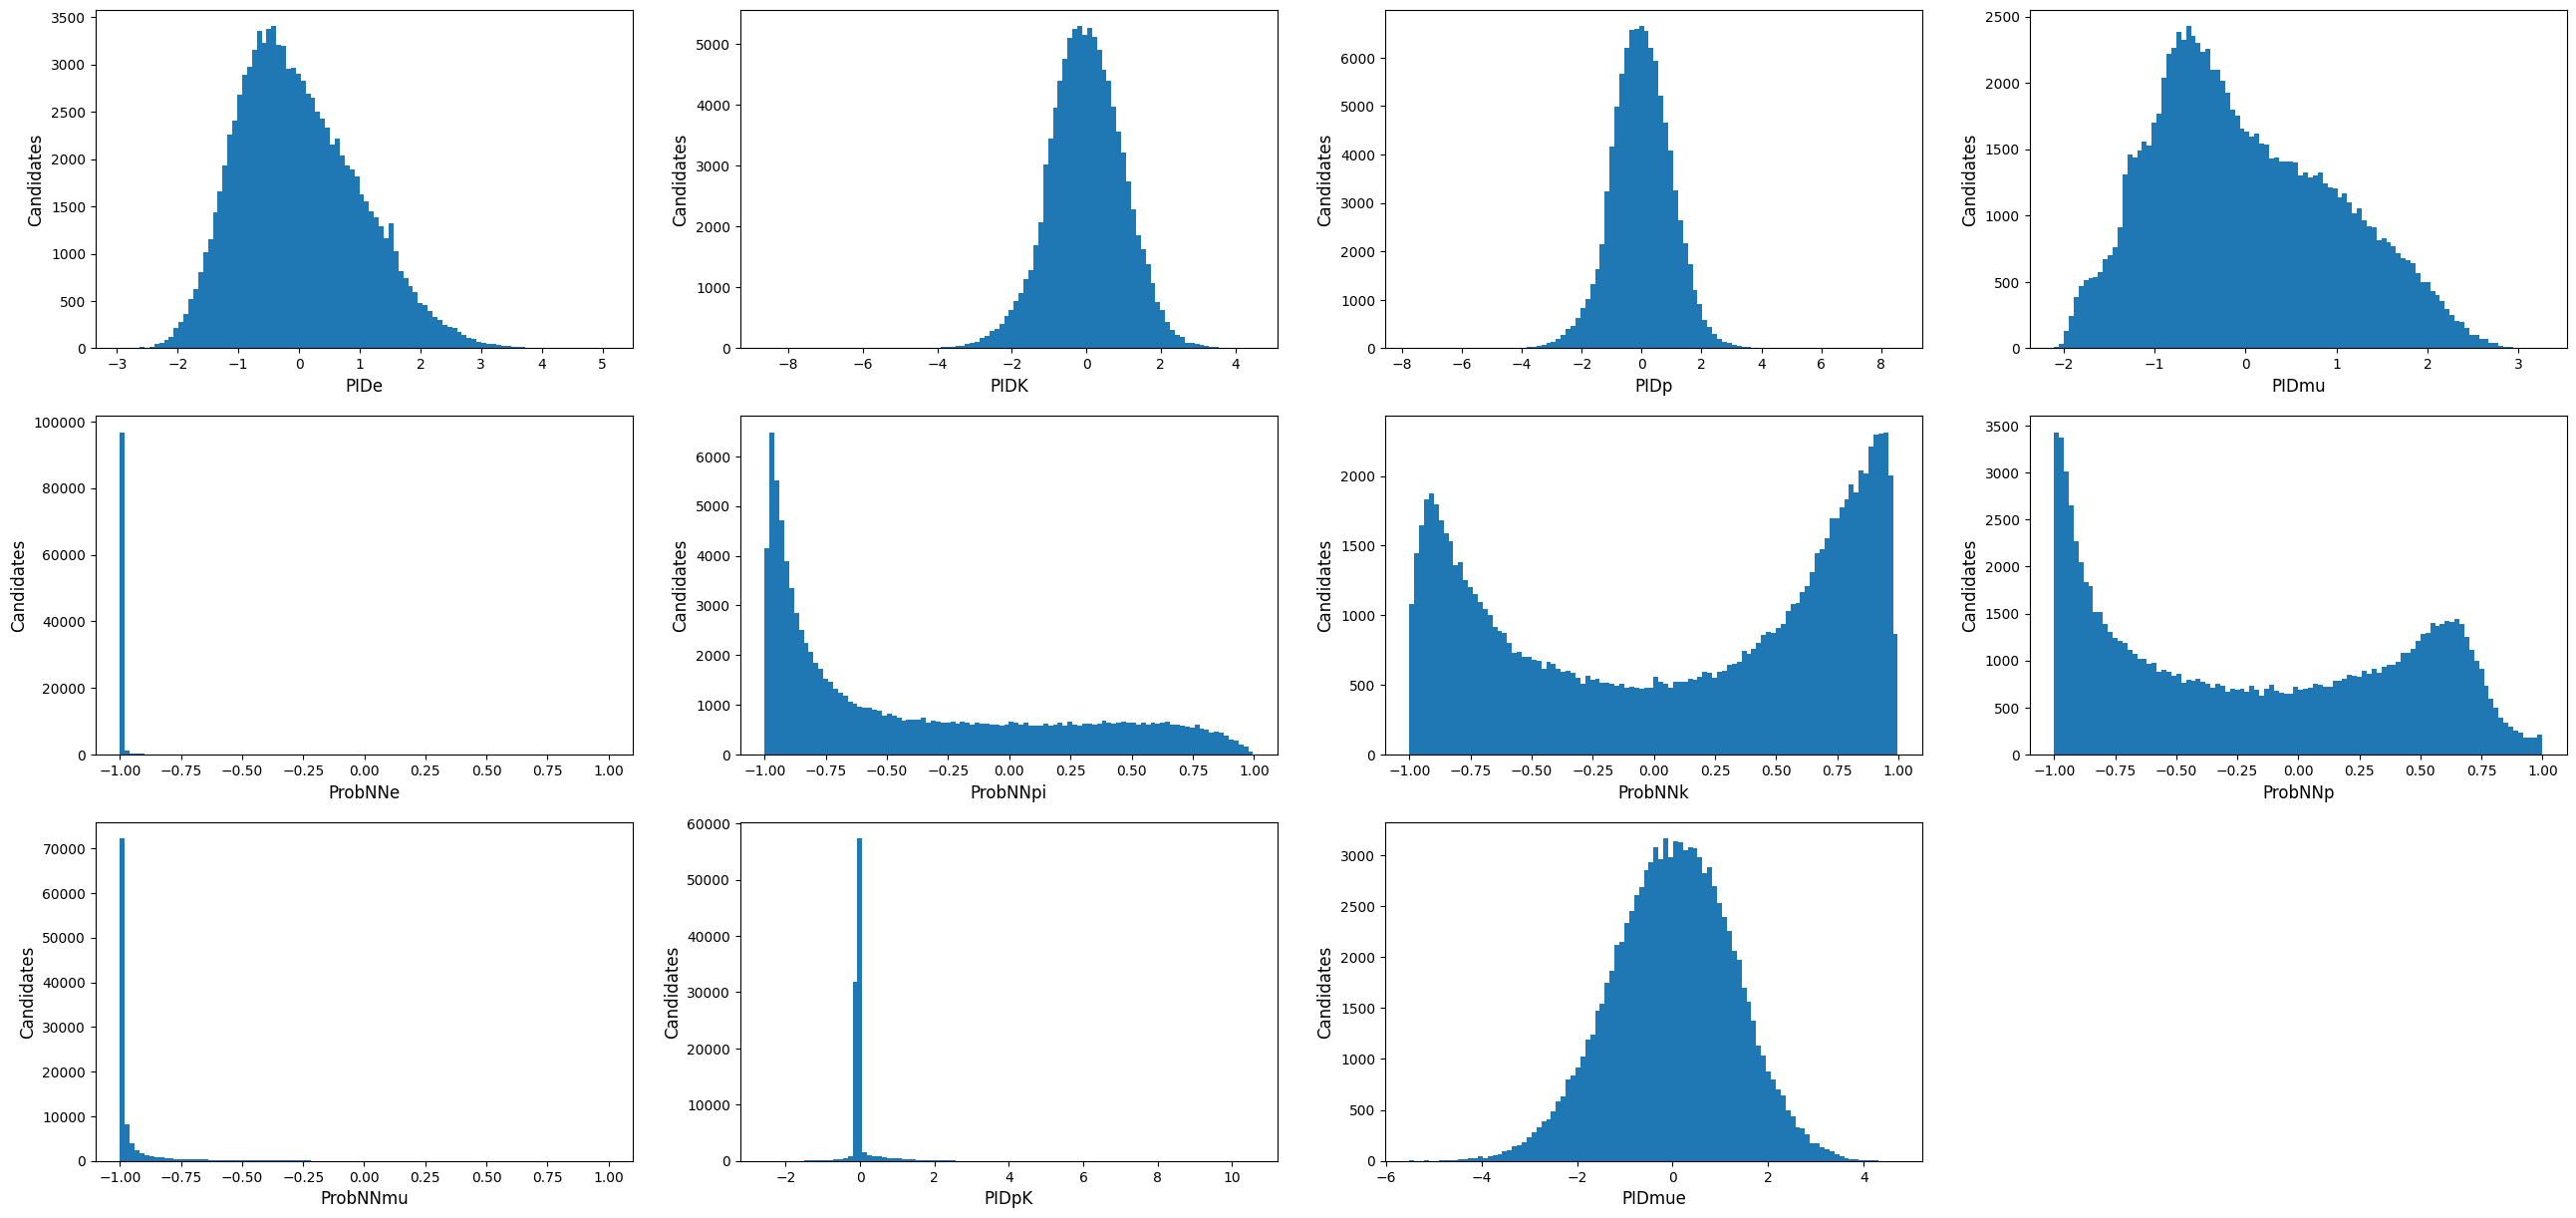

In [40]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_im):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_p[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_p[:, 2].numpy()[:100000] - y_p[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 11)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_p[:, 3].numpy()[:100000] - y_p[:, 0].numpy()[:100000], bins=100)

plt.show()

In [41]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-im-proton-{SAMPLE}-trainset.npz",
    x=X_p.numpy(),
    x_vars=conditions_im,
    y=y_p.numpy(),
    y_vars=target_im,
    w=None,
    w_var=None,
)

## `isMuon` not passed

In [42]:
selections_nm = [
  "probe_Brunel_P > 3000",
  "probe_Brunel_P < 200000", 
  "probe_Brunel_ETA > 1.5", 
  "probe_Brunel_ETA < 5.5",
  "probe_Brunel_isMuon == 0",
  "probe_Brunel_RichDLLe  > -150",
  "probe_Brunel_RichDLLmu > -150",
  "probe_Brunel_RichDLLk  > -150",
  "probe_Brunel_RichDLLp  > -150",
  "probe_Brunel_RichDLLe  <  150",
  "probe_Brunel_RichDLLmu <  150",
  "probe_Brunel_RichDLLk  <  150",
  "probe_Brunel_RichDLLp  <  150",
  "probe_Brunel_PIDe  > -25", 
  "probe_Brunel_PIDK  > -150", 
  "probe_Brunel_PIDp  > -150",
  "probe_Brunel_MC15TuneV1_ProbNNe  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNpi >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNk  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNp  >= 0", 
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000",
  "probe_Brunel_MuonUnbiased == 1",
]

cuts_nm = " and ".join([f"({s})" for s in selections_nm])

In [43]:
sim_nm = dict()

for part in particles:
    sim_nm[part] = (
        ddf.from_map(
            partial(read_root, tree=f"PidTupler/pid_{part}"),
            file_list,
        ).query(cuts_nm)
    )

### Features

In [44]:
for part in particles:
    sim_nm[part]["p_GeV"] = sim_nm[part].probe_Brunel_P/1e3
    # sim_nm[part]["log10_p"] = np.log10(sim_nm[part].probe_Brunel_P)
    sim_nm[part]["eta"] = sim_nm[part].probe_Brunel_ETA
    sim_nm[part] = sim_nm[part].map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
    sim_nm[part]["charge"] = sim_nm[part].probe_Brunel_trackcharge
    sim_nm[part]["RichDLLe"] = sim_nm[part].probe_Brunel_RichDLLe
    sim_nm[part]["RichDLLmu"] = sim_nm[part].probe_Brunel_RichDLLmu
    sim_nm[part]["RichDLLk"] = sim_nm[part].probe_Brunel_RichDLLk
    sim_nm[part]["RichDLLp"] = sim_nm[part].probe_Brunel_RichDLLp
    
    sim_nm[part]["PIDe"] = sim_nm[part].probe_Brunel_PIDe
    sim_nm[part]["PIDK"] = sim_nm[part].probe_Brunel_PIDK
    sim_nm[part]["PIDp"] = sim_nm[part].probe_Brunel_PIDp
    sim_nm[part]["ProbNNe"] = sim_nm[part].probe_Brunel_MC15TuneV1_ProbNNe
    sim_nm[part]["ProbNNpi"] = sim_nm[part].probe_Brunel_MC15TuneV1_ProbNNpi
    sim_nm[part]["ProbNNk"] = sim_nm[part].probe_Brunel_MC15TuneV1_ProbNNk
    sim_nm[part]["ProbNNp"] = sim_nm[part].probe_Brunel_MC15TuneV1_ProbNNp
    sim_nm[part]["PIDmu"] = sim_nm[part].probe_Brunel_PIDmu

In [45]:
real_conditions_nm = ["p_GeV", "eta", "nTracks_f", "RichDLLe", "RichDLLmu", "RichDLLk", "RichDLLp"]
flag_conditions_nm = ["charge"]

conditions_nm = real_conditions_nm + flag_conditions_nm
target_nm = ["PIDe", "PIDK", "PIDp", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp", "PIDmu"]

In [46]:
list_vars("Input features (real)", real_conditions_nm)
list_vars("Input features (boolean)", flag_conditions_nm)
list_vars("Output features (real)", target_nm)

In [47]:
dfs_nm = dict()

for part in particles:
    dfs_nm[part] = sim_nm[part][conditions_nm + target_nm].head(500_000, npartitions=30)
    print(f"Number of {part}s:", len(dfs_nm[part]))

Number of muons: 500000
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


#### Histograms

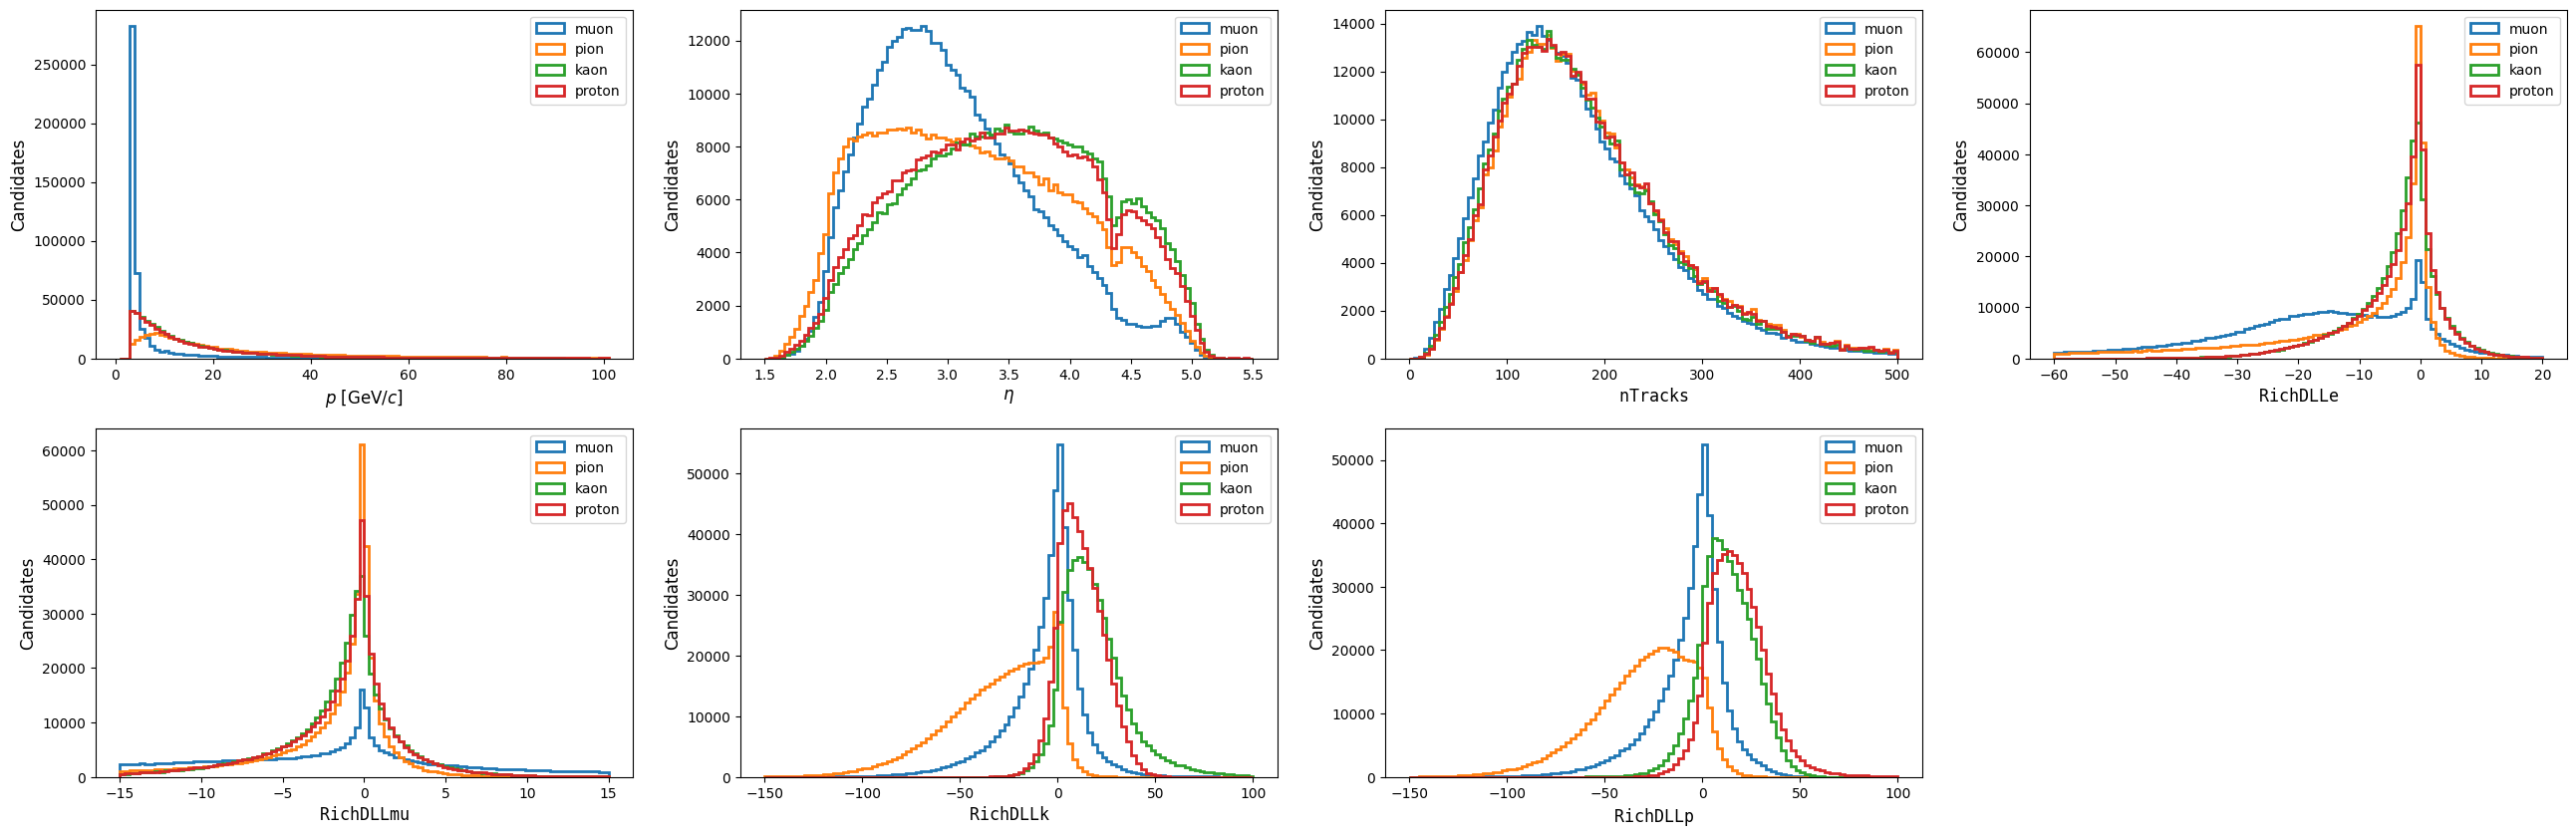

In [48]:
plt.figure(figsize=(32, 10), dpi=100)

plt.subplot(2, 4, 1)
plt.xlabel("$p$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["p_GeV"], bins=np.linspace(1.0, 101.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 2)
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 4)
plt.xlabel("$\mathtt{RichDLLe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["RichDLLe"], bins=np.linspace(-60.0, 20.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(2, 4, 5)
plt.xlabel("$\mathtt{RichDLLmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["RichDLLmu"], bins=np.linspace(-15.0, 15.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(2, 4, 6)
plt.xlabel("$\mathtt{RichDLLk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["RichDLLk"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 7)
plt.xlabel("$\mathtt{RichDLLp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["RichDLLp"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.show()

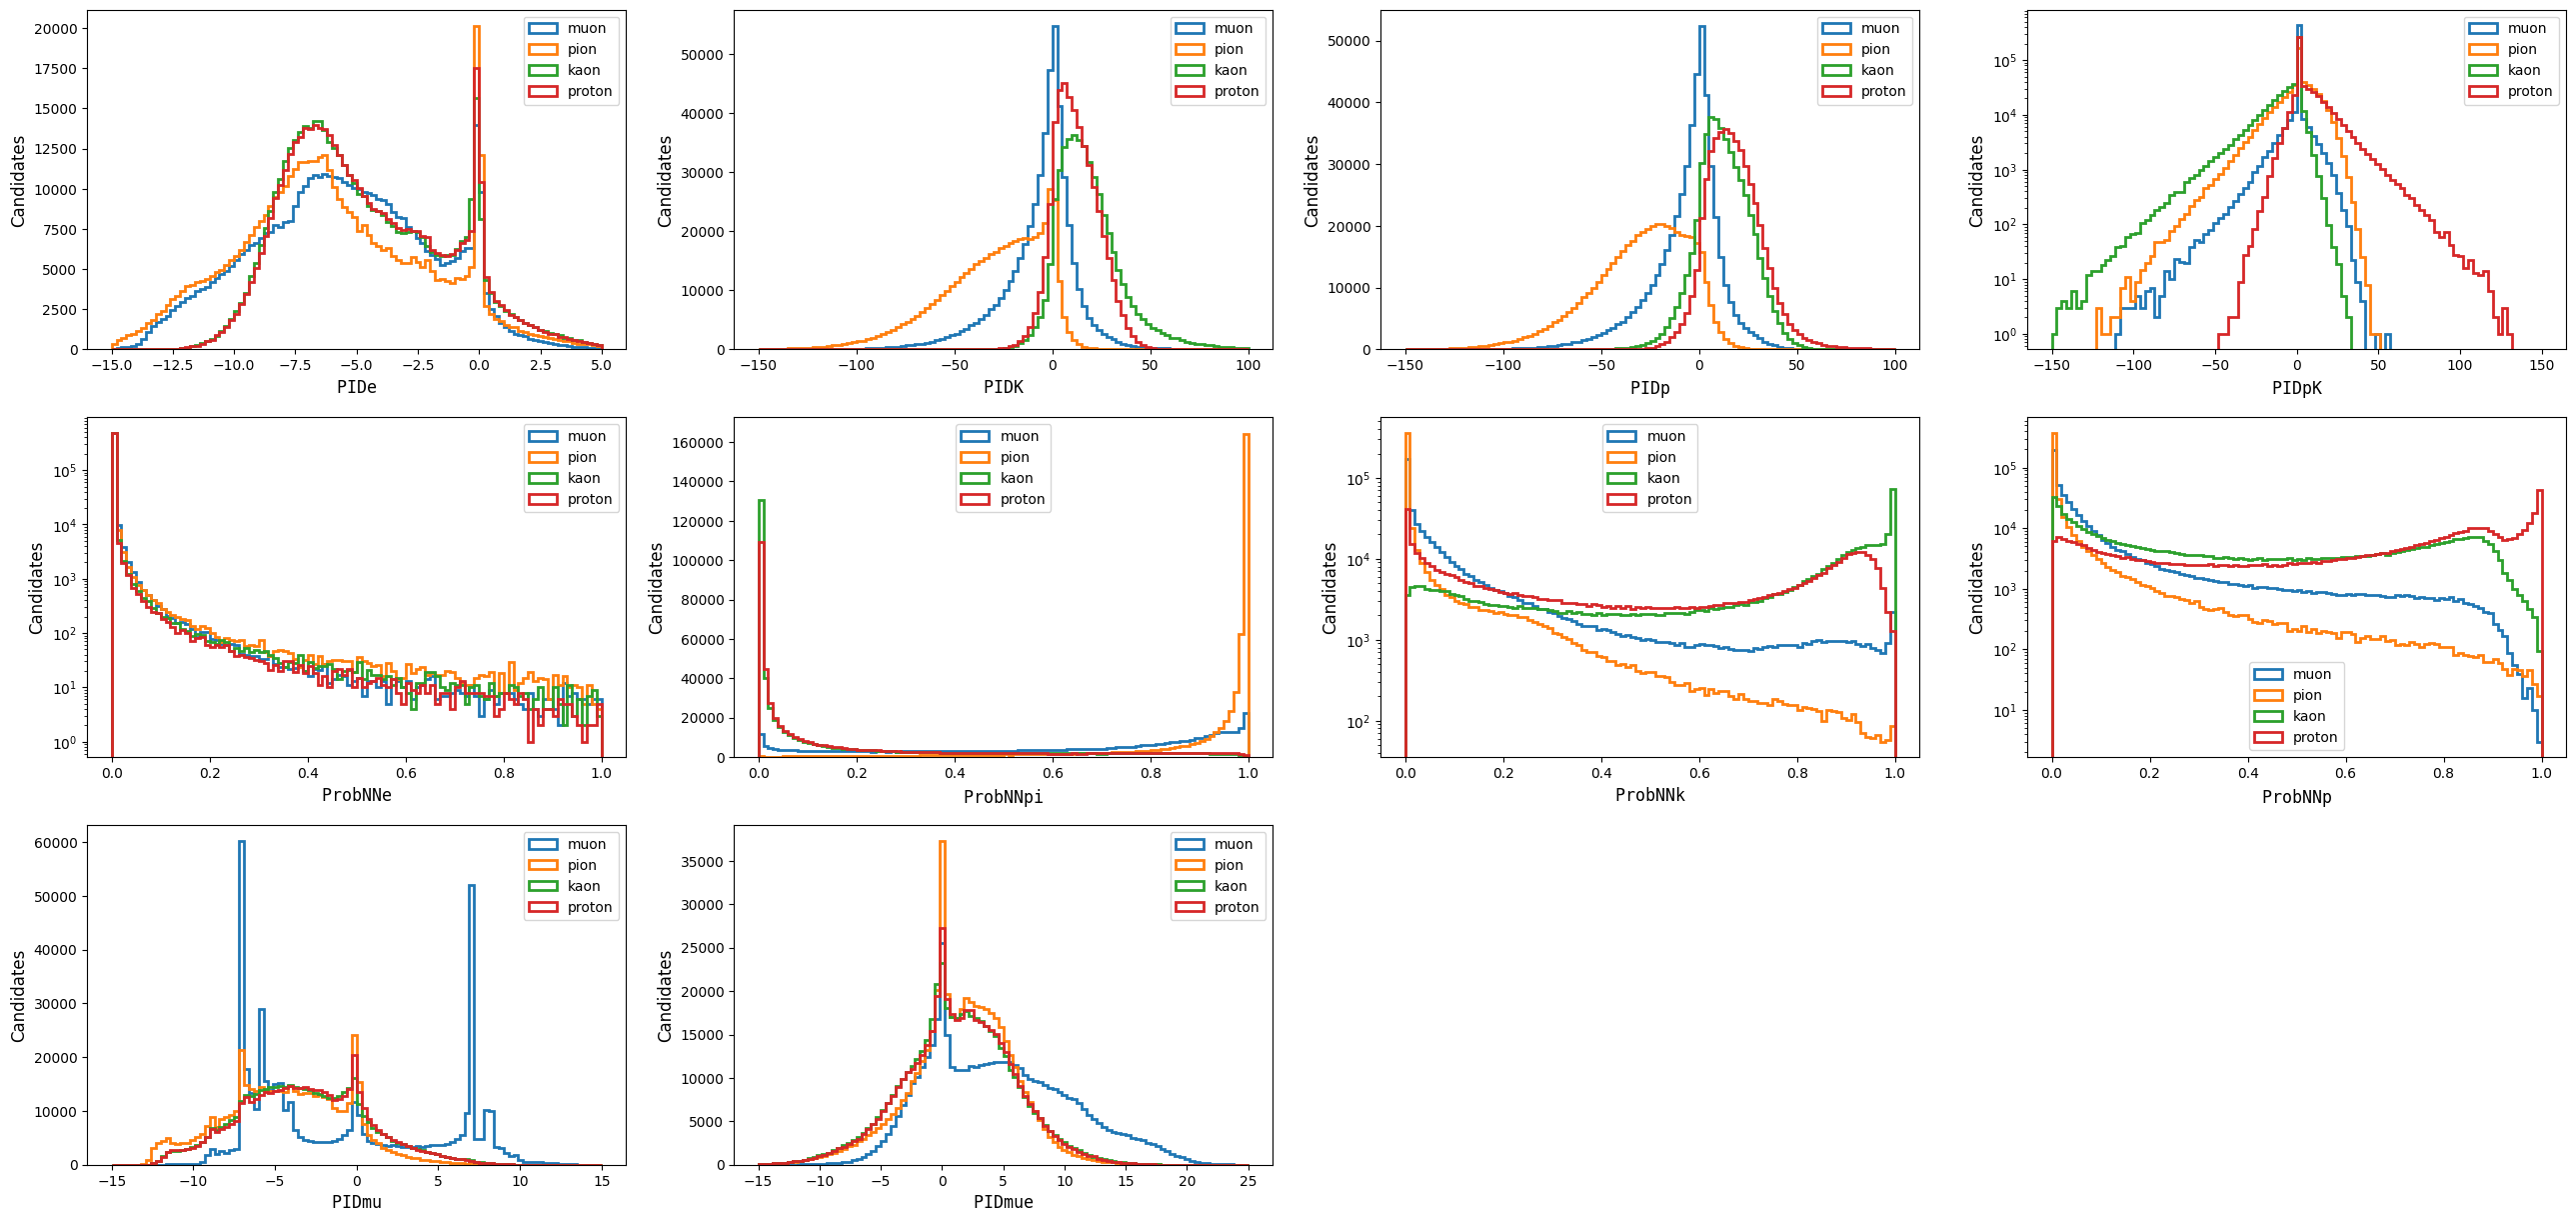

In [49]:
plt.figure(figsize=(32, 15), dpi=100)

plt.subplot(3, 4, 1)
plt.xlabel("$\mathtt{PIDe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDe"], bins=np.linspace(-15.0, 5.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 2)
plt.xlabel("$\mathtt{PIDK}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDK"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 3)
plt.xlabel("$\mathtt{PIDp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDp"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 4)
plt.xlabel("$\mathtt{PIDpK}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDp"] - dfs_nm[part]["PIDK"], bins=np.linspace(-150.0, 150.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 5)
plt.xlabel("$\mathtt{ProbNNe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["ProbNNe"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 6)
plt.xlabel("$\mathtt{ProbNNpi}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["ProbNNpi"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 7)
plt.xlabel("$\mathtt{ProbNNk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["ProbNNk"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 8)
plt.xlabel("$\mathtt{ProbNNp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["ProbNNp"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 9)
plt.xlabel("$\mathtt{PIDmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDmu"], bins=np.linspace(-15.0, 15.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 10)
plt.xlabel("$\mathtt{PIDmue}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs_nm[part]["PIDmu"] - dfs_nm[part]["PIDe"], bins=np.linspace(-15.0, 25.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.show()

### Preprocessing

In [50]:
n_features = len(real_conditions_nm)
n_flags = len(flag_conditions_nm)
n_target = len(target_nm)

prep_step_x_nm = dict()
for part in particles:
    prep_step_x_nm[part] = ColumnTransformer(
        [
            ('quantile', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
            ('flags', "passthrough", n_features + np.arange(n_flags)),
        ]
    ).fit(dfs_nm[part][conditions_nm].values)

prep_step_y_nm = dict()
for part in particles:
    prep_step_y_nm[part] = ColumnTransformer(
        [
            ('standard', StandardScaler(), [0, 1, 2, 7]),
            ('probs', MinMaxScaler(feature_range=(-1.0, 1.0)), [3, 4, 5, 6]),
        ]
    ).fit(dfs_nm[part][target_nm].values)

In [51]:
for part in particles:
    display(
        store_as_pickle(
            prep_step_x_nm[part],
            f"GLOBALPID_NM_{part.upper()}_PREPROCESSING_X",
            f"/home/mabarbet/PythonFastSim/models/GlobalPID-nm_{part}_models/tX_{SAMPLE}.pkl",
        )
    )
    display(
        store_as_pickle(
            prep_step_y_nm[part],
            f"GLOBALPID_NM_{part.upper()}_PREPROCESSING_Y",
            f"/home/mabarbet/PythonFastSim/models/GlobalPID-nm_{part}_models/tY_{SAMPLE}.pkl",
        )
    )

### Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

#### Muons

In [52]:
entries = split_and_store(
    sim_nm["muon"][conditions_nm + target_nm],
    [
        (0.5, environ.get("GLOBALPID_NM_MUON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-muon-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_NM_MUON_TEST", f"{DATA_PATH}/GlobalPID-nm-muon-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_NM_MUON_VALIDATION", f"{DATA_PATH}/GlobalPID-nm-muon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_nm,
    labels=target_nm,
    preprocessorX=prep_step_x_nm["muon"],
    preprocessorY=prep_step_y_nm["muon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-muon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-muon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-muon-2016MU-validation


,0
Train,2671417
Test,2135761
Validation,534220


In [53]:
reader_train =  FeatherReader(environ.get("GLOBALPID_NM_MUON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-muon-{SAMPLE}-train"), max_files=3)
ds_train_mu = reader_train.as_tf_dataset()

In [54]:
X_mu, y_mu = next(iter(ds_train_mu.batch(2_000_000)))
X_mu.shape, y_mu.shape

(TensorShape([2000000, 8]), TensorShape([2000000, 8]))

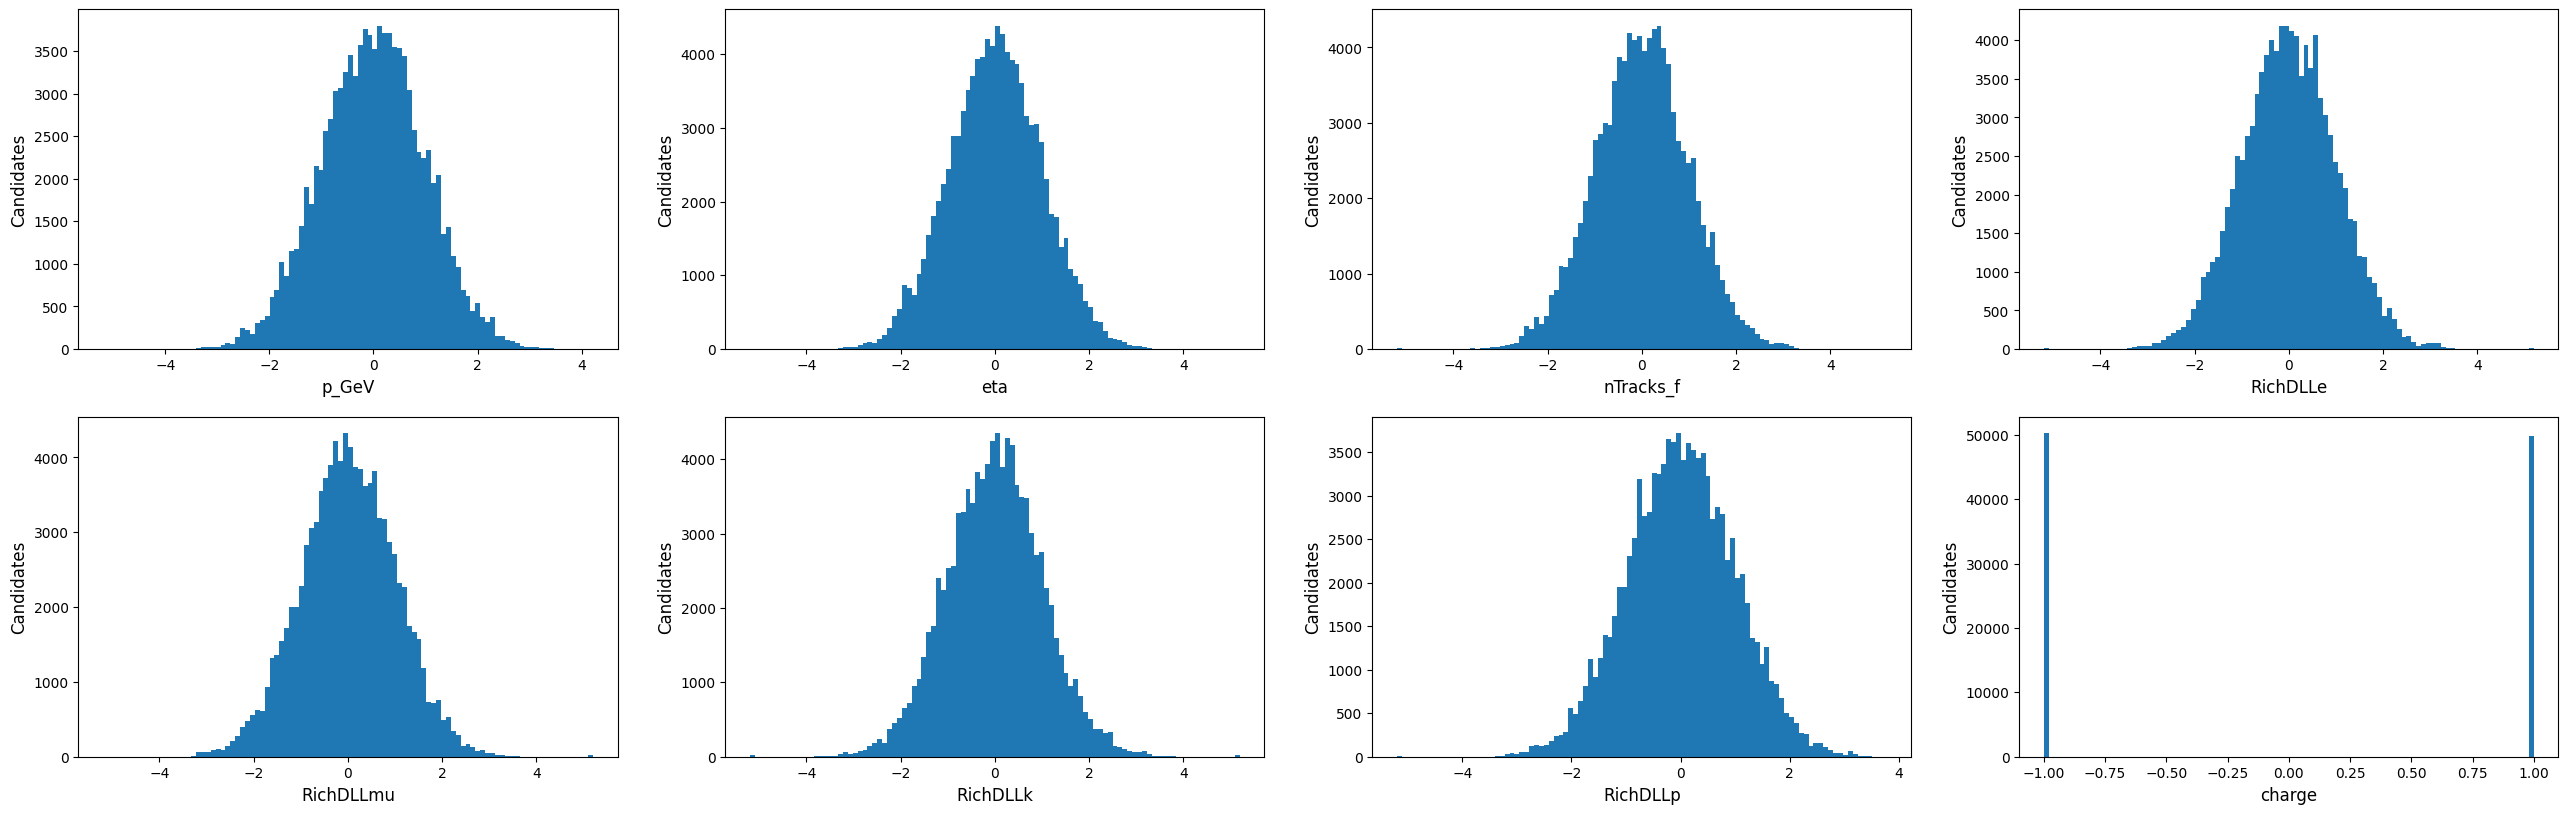

In [55]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_mu[:, i].numpy()[:100000], bins=100)

plt.show()

In [56]:
reord_target_nm = ["PIDe", "PIDK", "PIDp", "PIDmu", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp"]

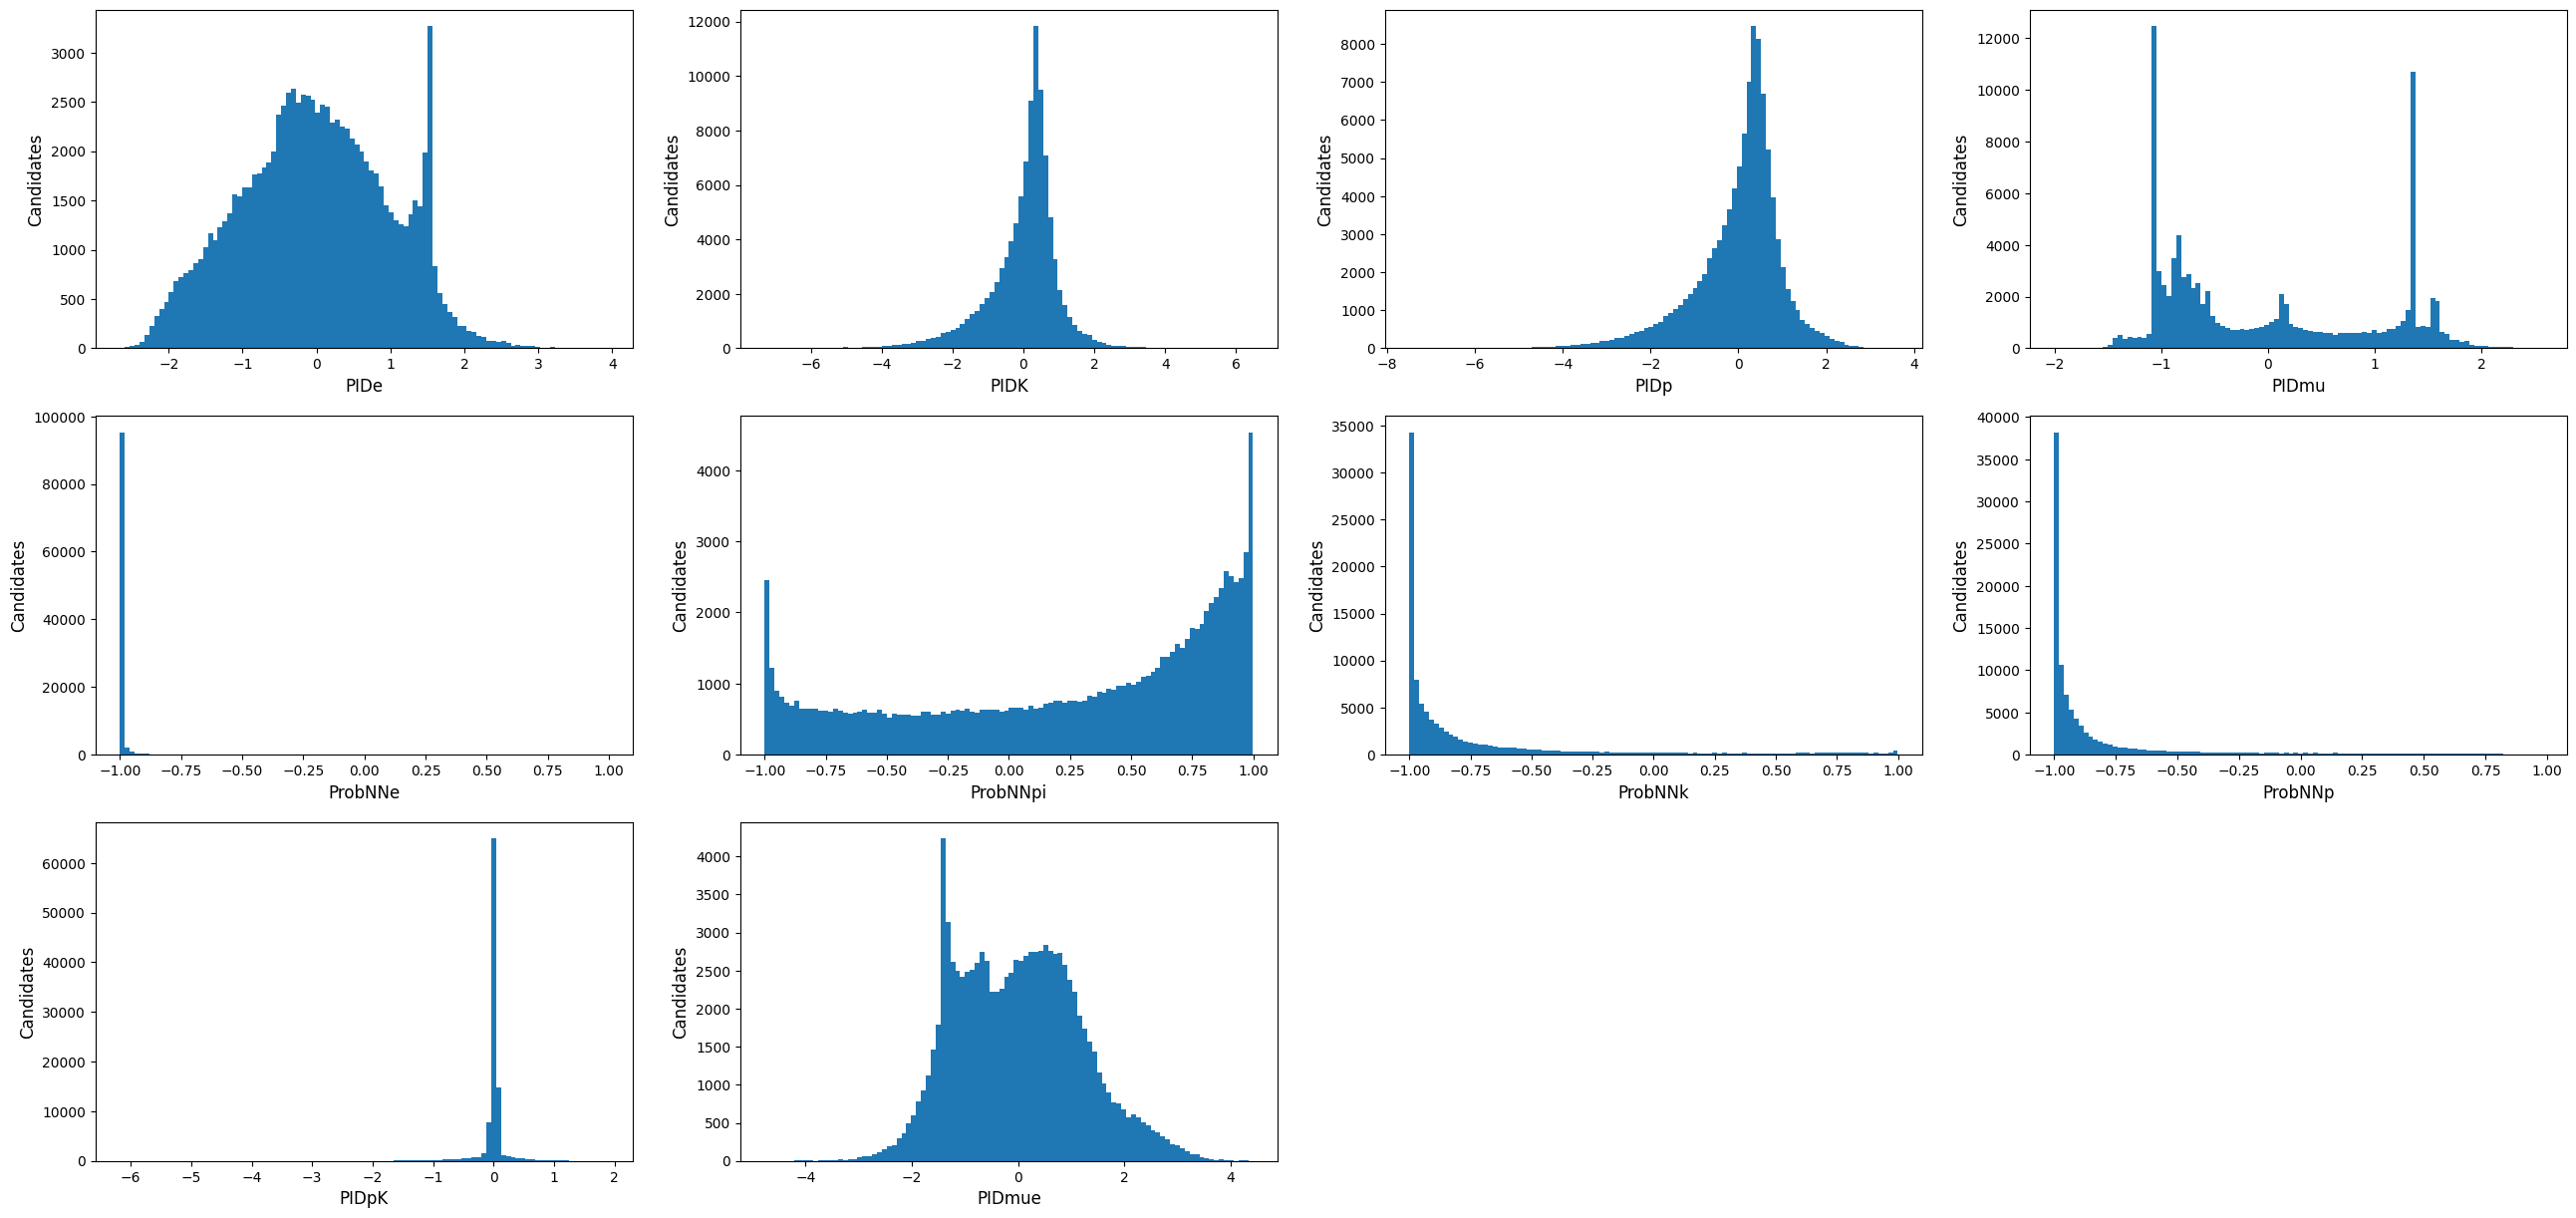

In [57]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_mu[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 9)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_mu[:, 2].numpy()[:100000] - y_mu[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_mu[:, 3].numpy()[:100000] - y_mu[:, 0].numpy()[:100000], bins=100)

plt.show()

In [58]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-nm-muon-{SAMPLE}-trainset.npz",
    x=X_mu.numpy(),
    x_vars=conditions_nm,
    y=y_mu.numpy(),
    y_vars=target_nm,
    w=None,
    w_var=None,
)

#### Pions

In [59]:
entries = split_and_store(
    sim_nm["pion"][conditions_nm + target_nm],
    [
        (0.5, environ.get("GLOBALPID_NM_PION_TRAIN", f"{DATA_PATH}/GlobalPID-nm-pion-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_NM_PION_TEST", f"{DATA_PATH}/GlobalPID-nm-pion-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_NM_PION_VALIDATION", f"{DATA_PATH}/GlobalPID-nm-pion-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_nm,
    labels=target_nm,
    preprocessorX=prep_step_x_nm["pion"],
    preprocessorY=prep_step_y_nm["pion"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-pion-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-pion-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-pion-2016MU-validation


,0
Train,53698098
Test,42958295
Validation,10739969


In [60]:
reader_train =  FeatherReader(environ.get("GLOBALPID_NM_PION_TRAIN", f"{DATA_PATH}/GlobalPID-nm-pion-{SAMPLE}-train"), max_files=3)
ds_train_pi = reader_train.as_tf_dataset()

In [61]:
X_pi, y_pi = next(iter(ds_train_pi.batch(2_000_000)))
X_pi.shape, y_pi.shape

(TensorShape([2000000, 8]), TensorShape([2000000, 8]))

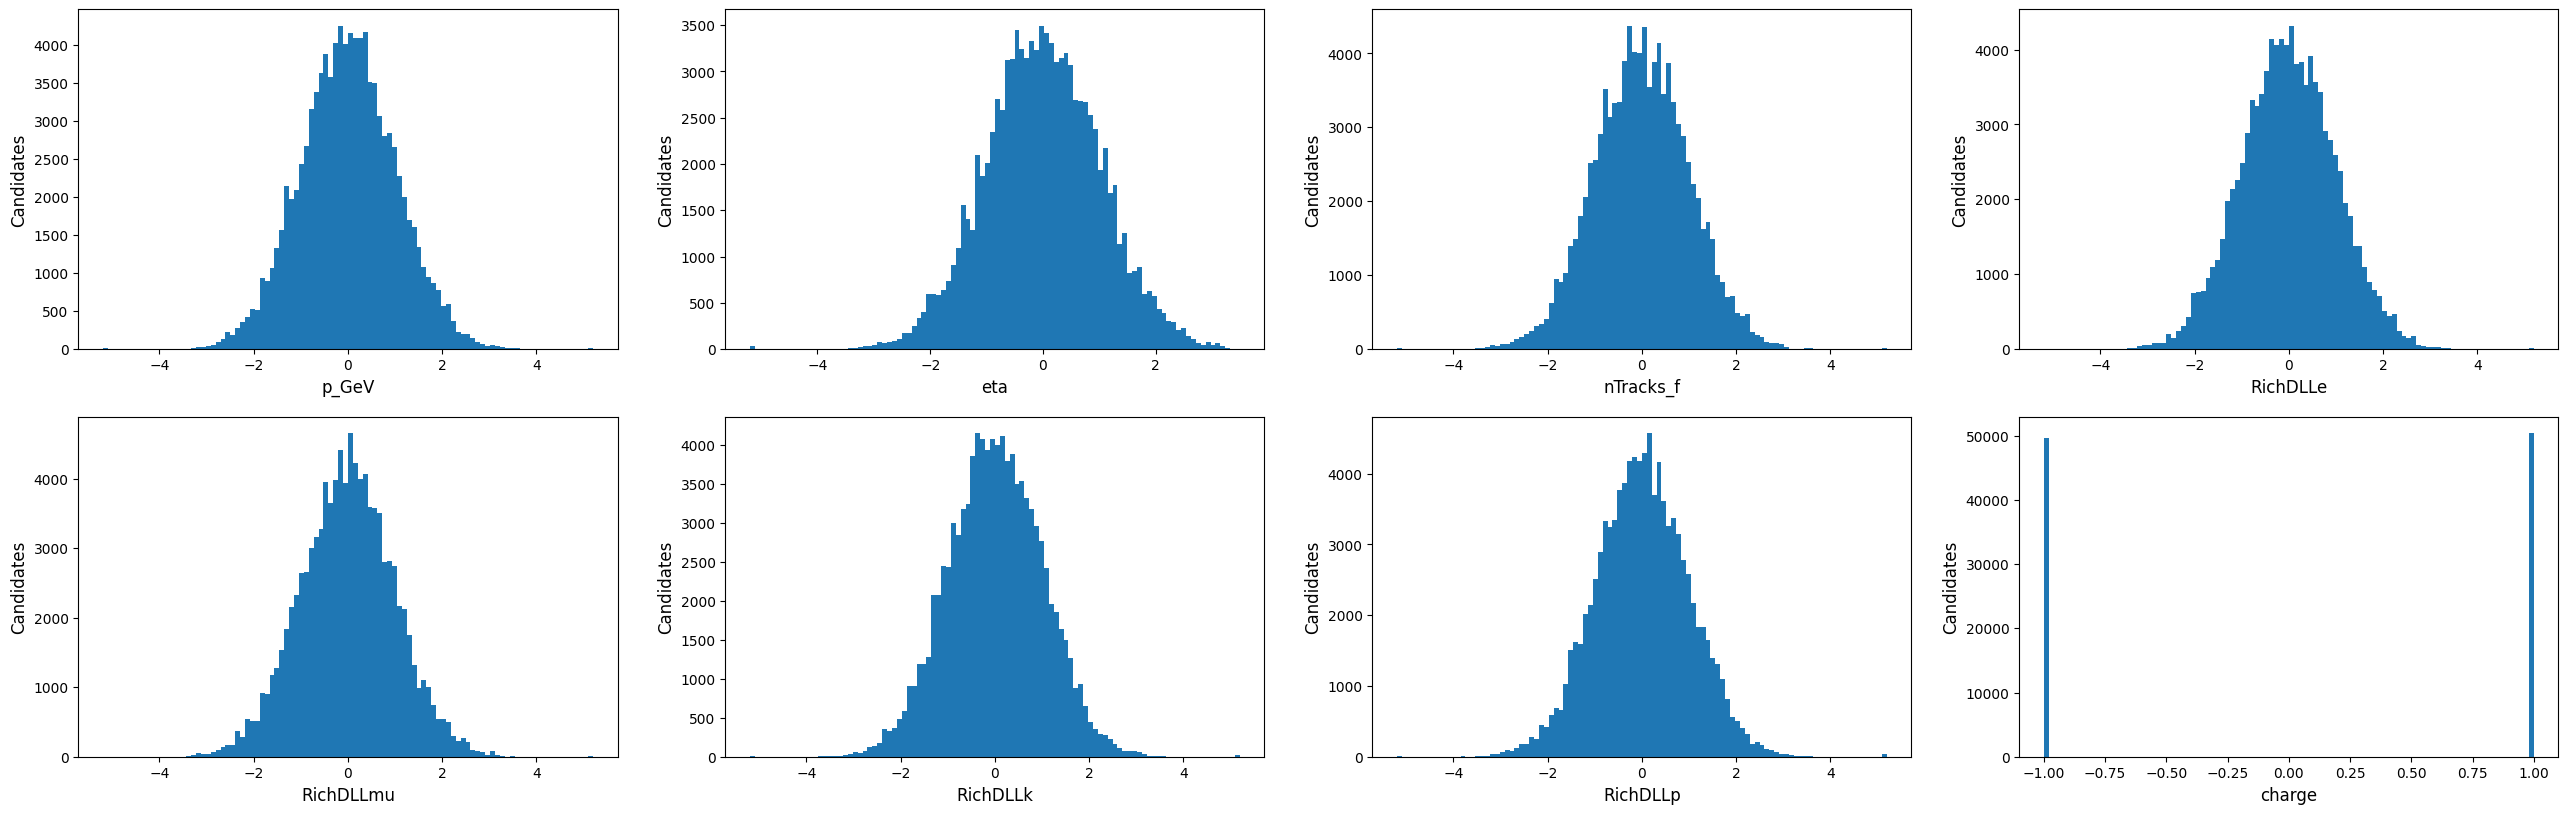

In [62]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_pi[:, i].numpy()[:100000], bins=100)

plt.show()

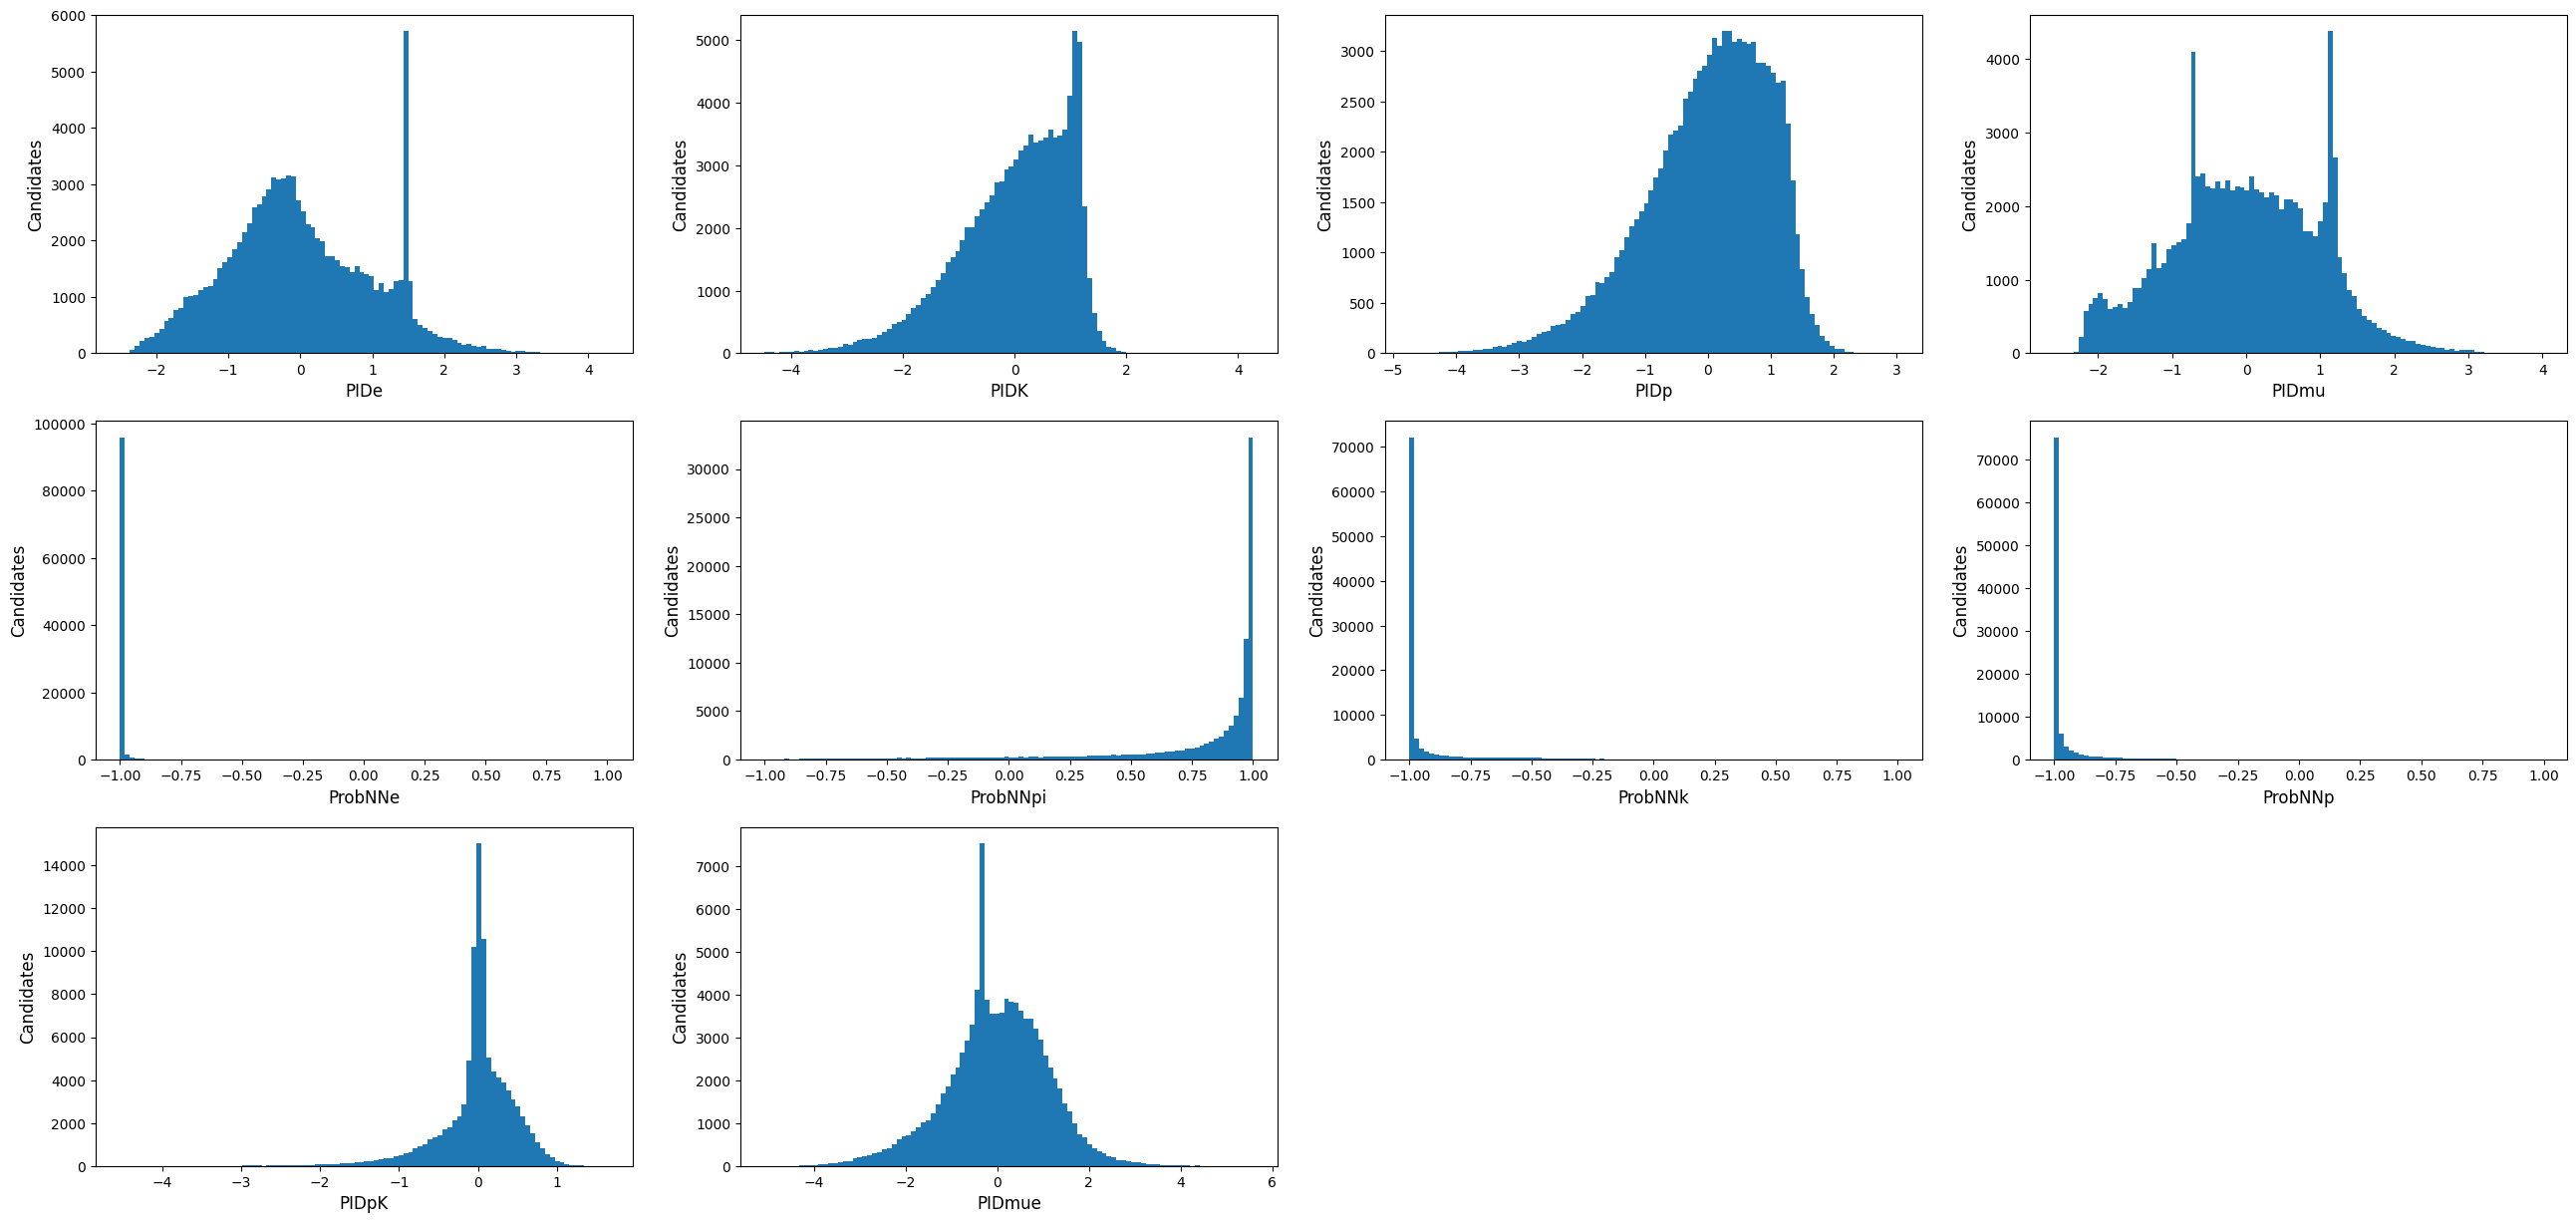

In [63]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_pi[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 9)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_pi[:, 2].numpy()[:100000] - y_pi[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_pi[:, 3].numpy()[:100000] - y_pi[:, 0].numpy()[:100000], bins=100)

plt.show()

In [64]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-nm-pion-{SAMPLE}-trainset.npz",
    x=X_pi.numpy(),
    x_vars=conditions_nm,
    y=y_pi.numpy(),
    y_vars=target_nm,
    w=None,
    w_var=None,
)

#### Kaons

In [65]:
entries = split_and_store(
    sim_nm["kaon"][conditions_nm + target_nm],
    [
        (0.5, environ.get("GLOBALPID_NM_KAON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-kaon-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_NM_KAON_TEST", f"{DATA_PATH}/GlobalPID-nm-kaon-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_NM_KAON_VALIDATION", f"{DATA_PATH}/GlobalPID-nm-kaon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_nm,
    labels=target_nm,
    preprocessorX=prep_step_x_nm["kaon"],
    preprocessorY=prep_step_y_nm["kaon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-kaon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-kaon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-kaon-2016MU-validation


,0
Train,87945805
Test,70365503
Validation,17584578


In [66]:
reader_train =  FeatherReader(environ.get("GLOBALPID_NM_KAON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-kaon-{SAMPLE}-train"), max_files=3)
ds_train_k = reader_train.as_tf_dataset()

In [67]:
X_k, y_k = next(iter(ds_train_k.batch(2_000_000)))
X_k.shape, y_k.shape

(TensorShape([2000000, 8]), TensorShape([2000000, 8]))

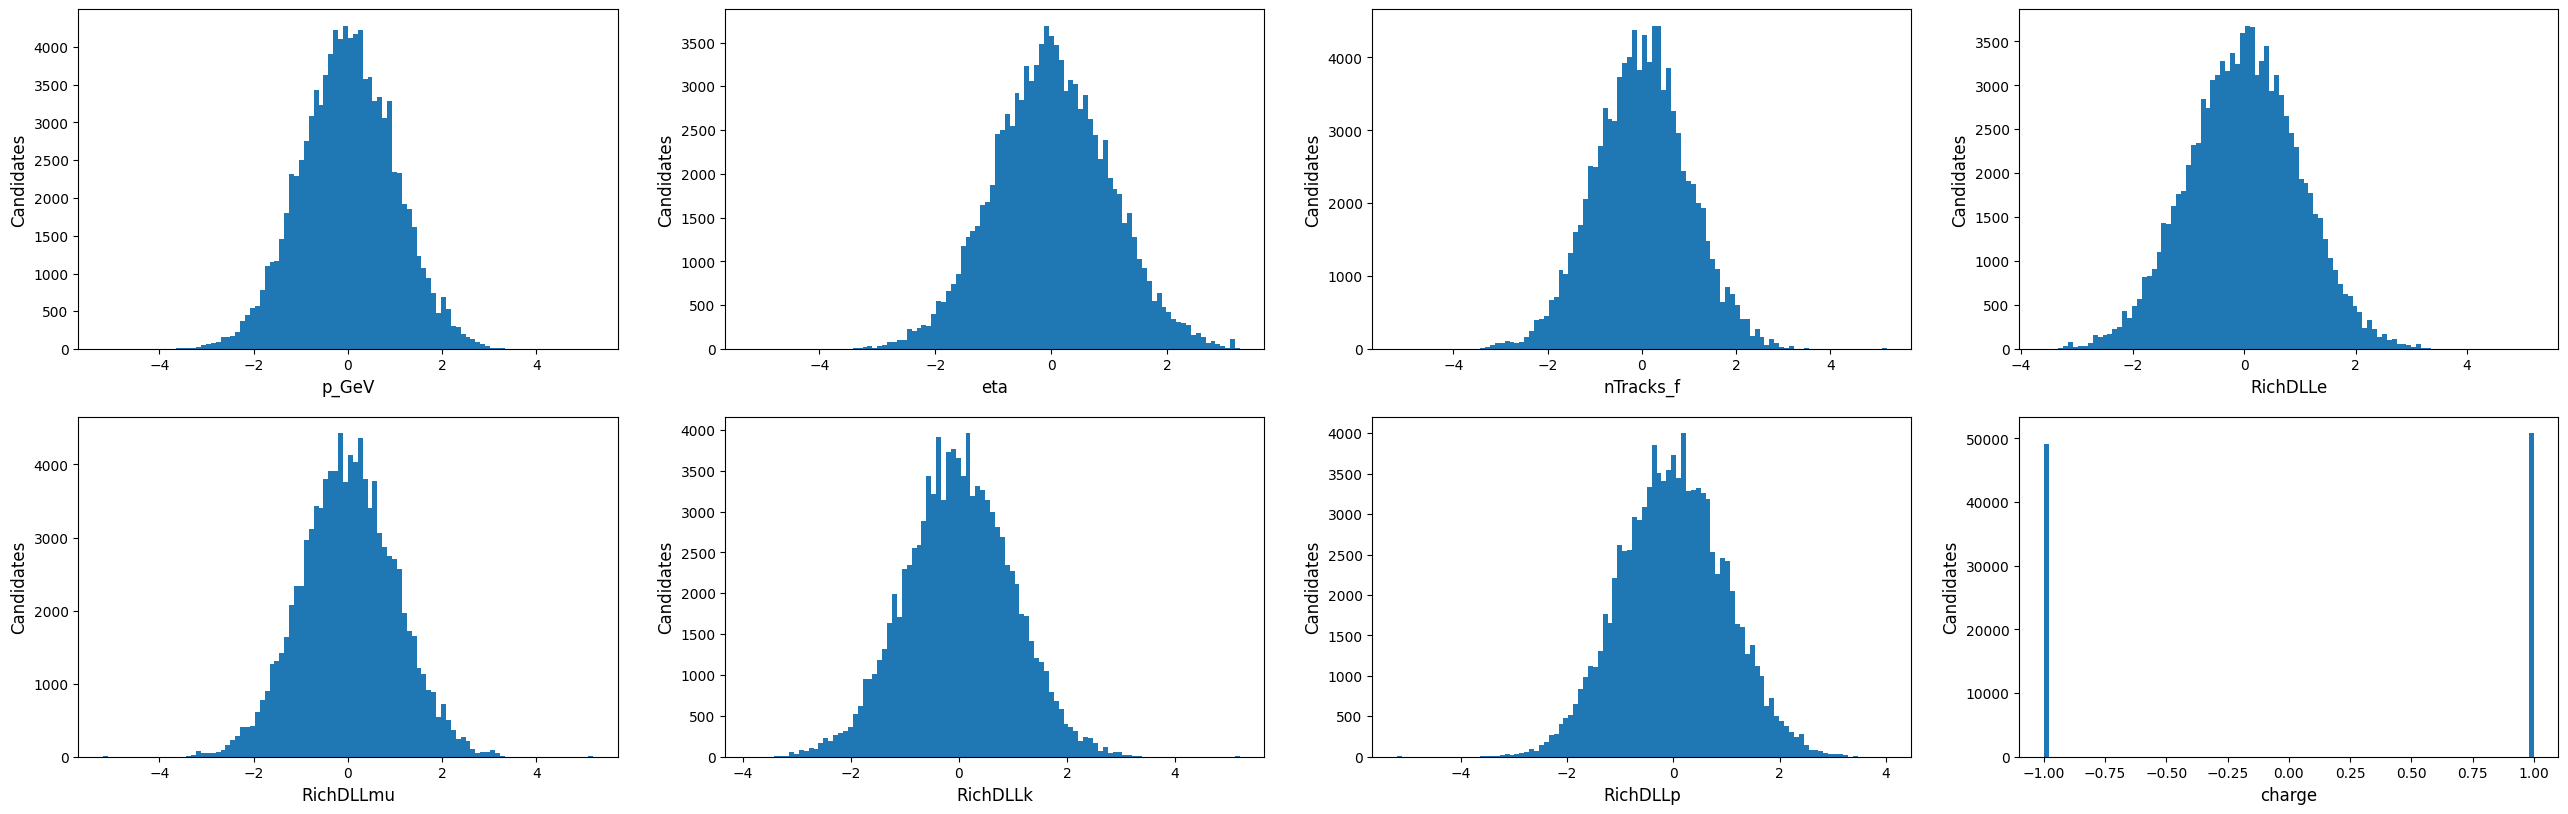

In [68]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_k[:, i].numpy()[:100000], bins=100)

plt.show()

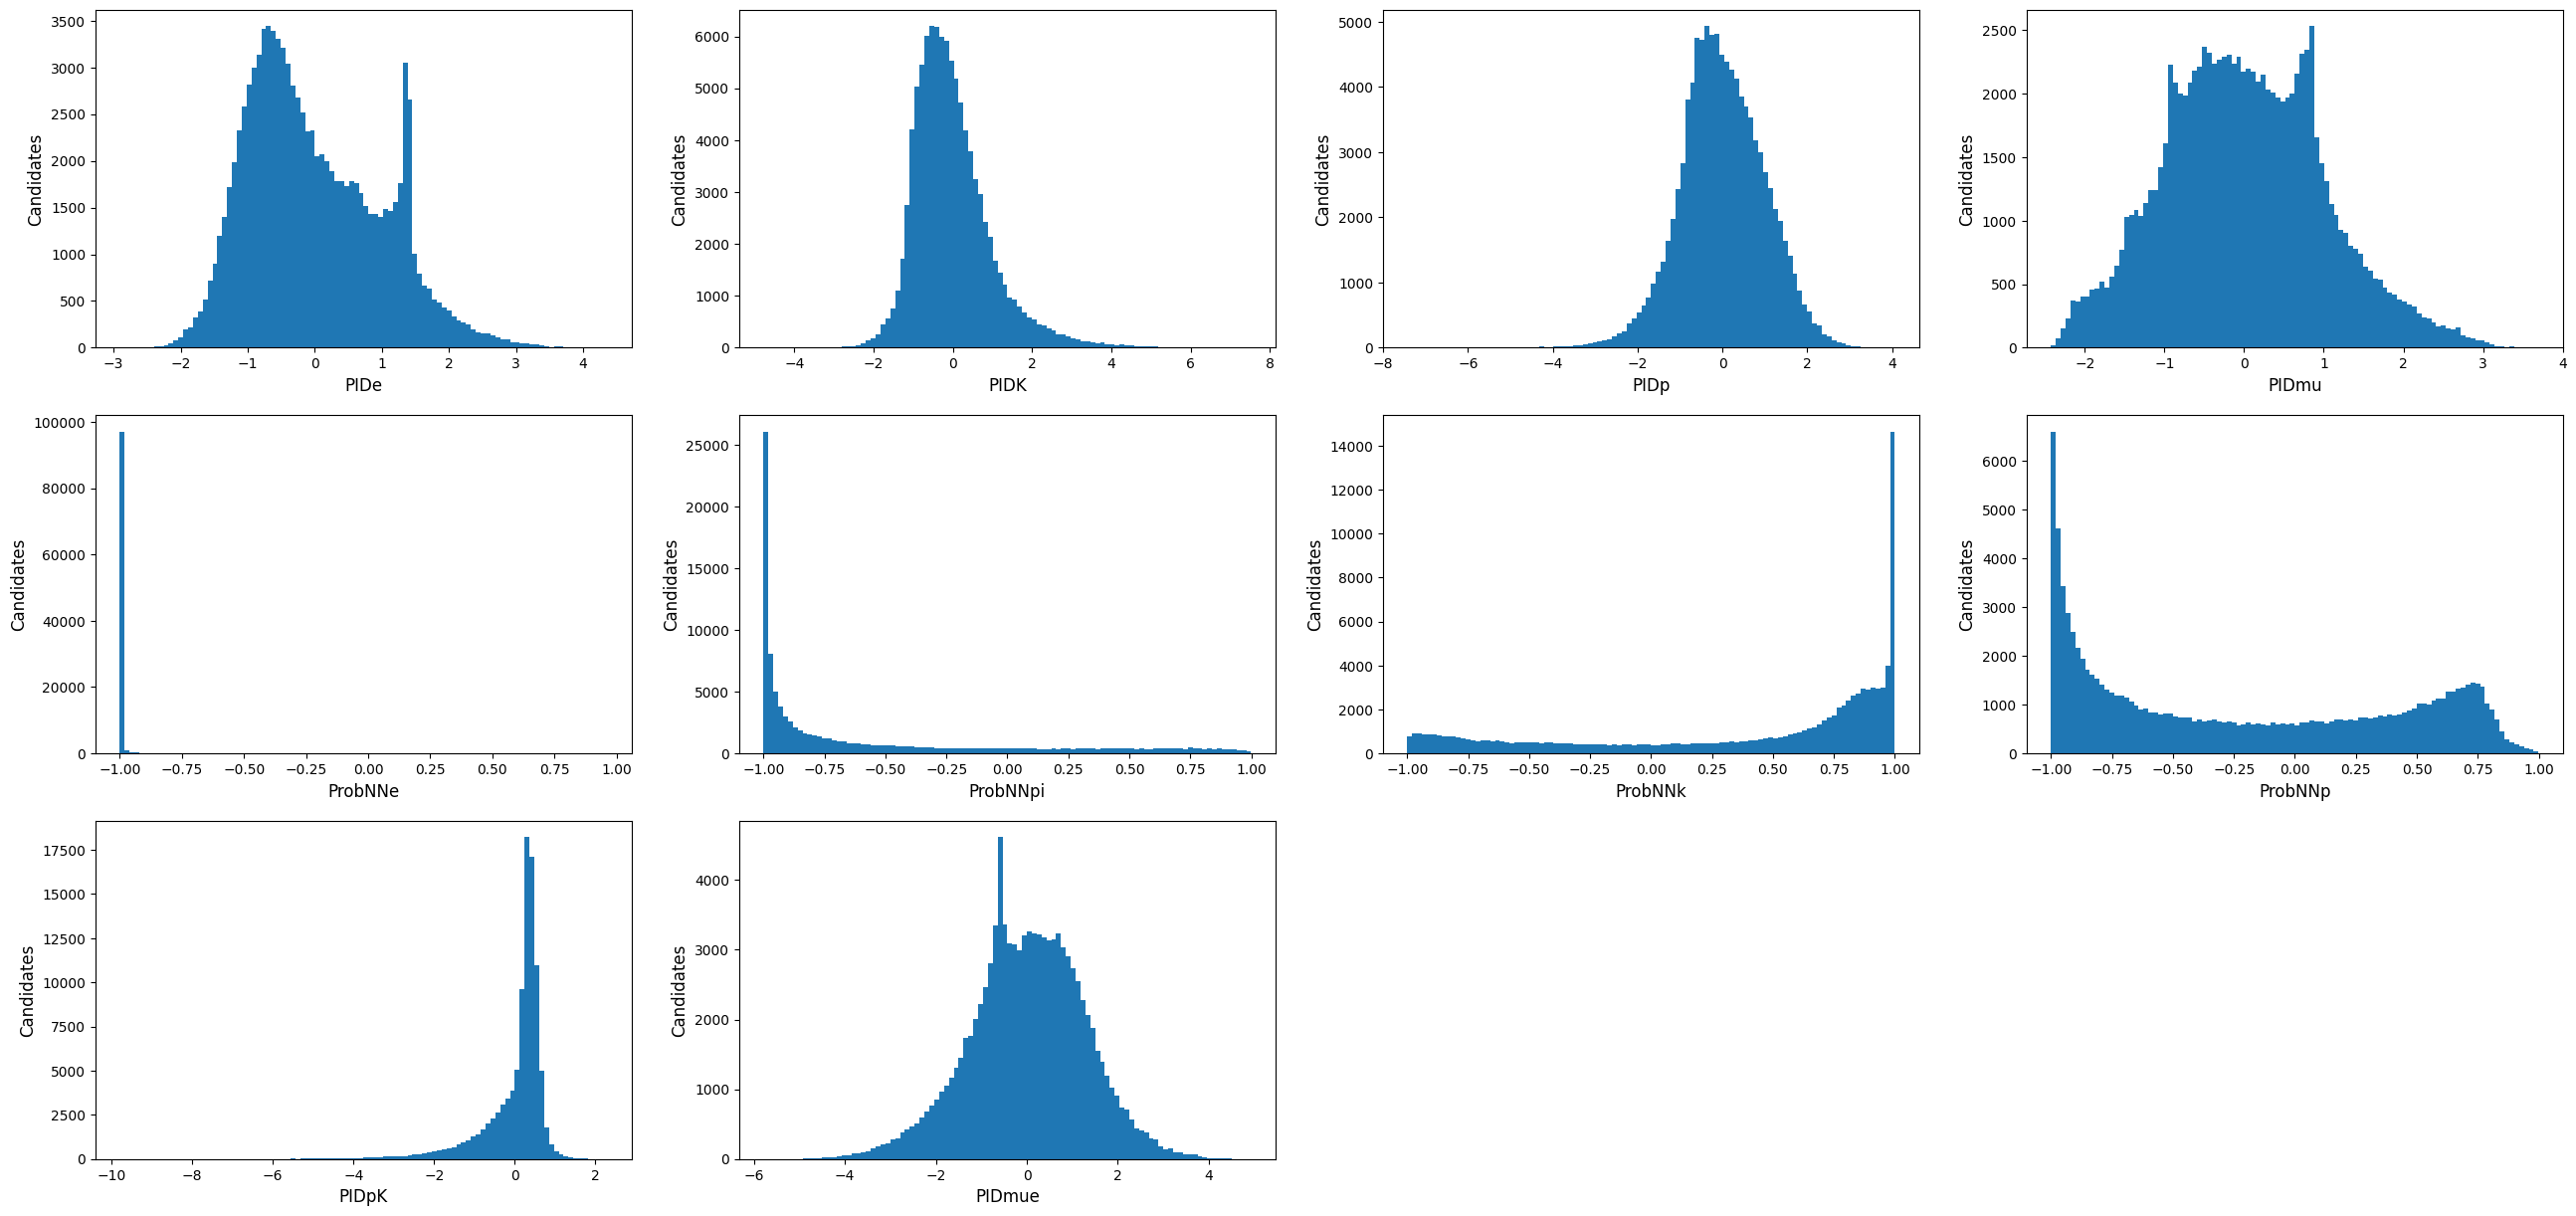

In [69]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_k[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 9)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_k[:, 2].numpy()[:100000] - y_k[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_k[:, 3].numpy()[:100000] - y_k[:, 0].numpy()[:100000], bins=100)

plt.show()

In [70]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-nm-kaon-{SAMPLE}-trainset.npz",
    x=X_k.numpy(),
    x_vars=conditions_nm,
    y=y_k.numpy(),
    y_vars=target_nm,
    w=None,
    w_var=None,
)

#### Protons

In [71]:
entries = split_and_store(
    sim_nm["proton"][conditions_nm + target_nm],
    [
        (0.5, environ.get("GLOBALPID_NM_PROTON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-proton-{SAMPLE}-train")),
        (0.4, environ.get("GLOBALPID_NM_PROTON_TEST", f"{DATA_PATH}/GlobalPID-nm-proton-{SAMPLE}-test")),
        (0.1, environ.get("GLOBALPID_NM_PROTON_VALIDATION", f"{DATA_PATH}/GlobalPID-nm-proton-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions_nm,
    labels=target_nm,
    preprocessorX=prep_step_x_nm["proton"],
    preprocessorY=prep_step_y_nm["proton"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-proton-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-proton-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/GlobalPID-nm-proton-2016MU-validation


,0
Train,64019394
Test,51217138
Validation,12810295


In [72]:
reader_train =  FeatherReader(environ.get("GLOBALPID_NM_PROTON_TRAIN", f"{DATA_PATH}/GlobalPID-nm-proton-{SAMPLE}-train"), max_files=3)
ds_train_p = reader_train.as_tf_dataset()

In [73]:
X_p, y_p = next(iter(ds_train_p.batch(2_000_000)))
X_p.shape, y_p.shape

(TensorShape([2000000, 8]), TensorShape([2000000, 8]))

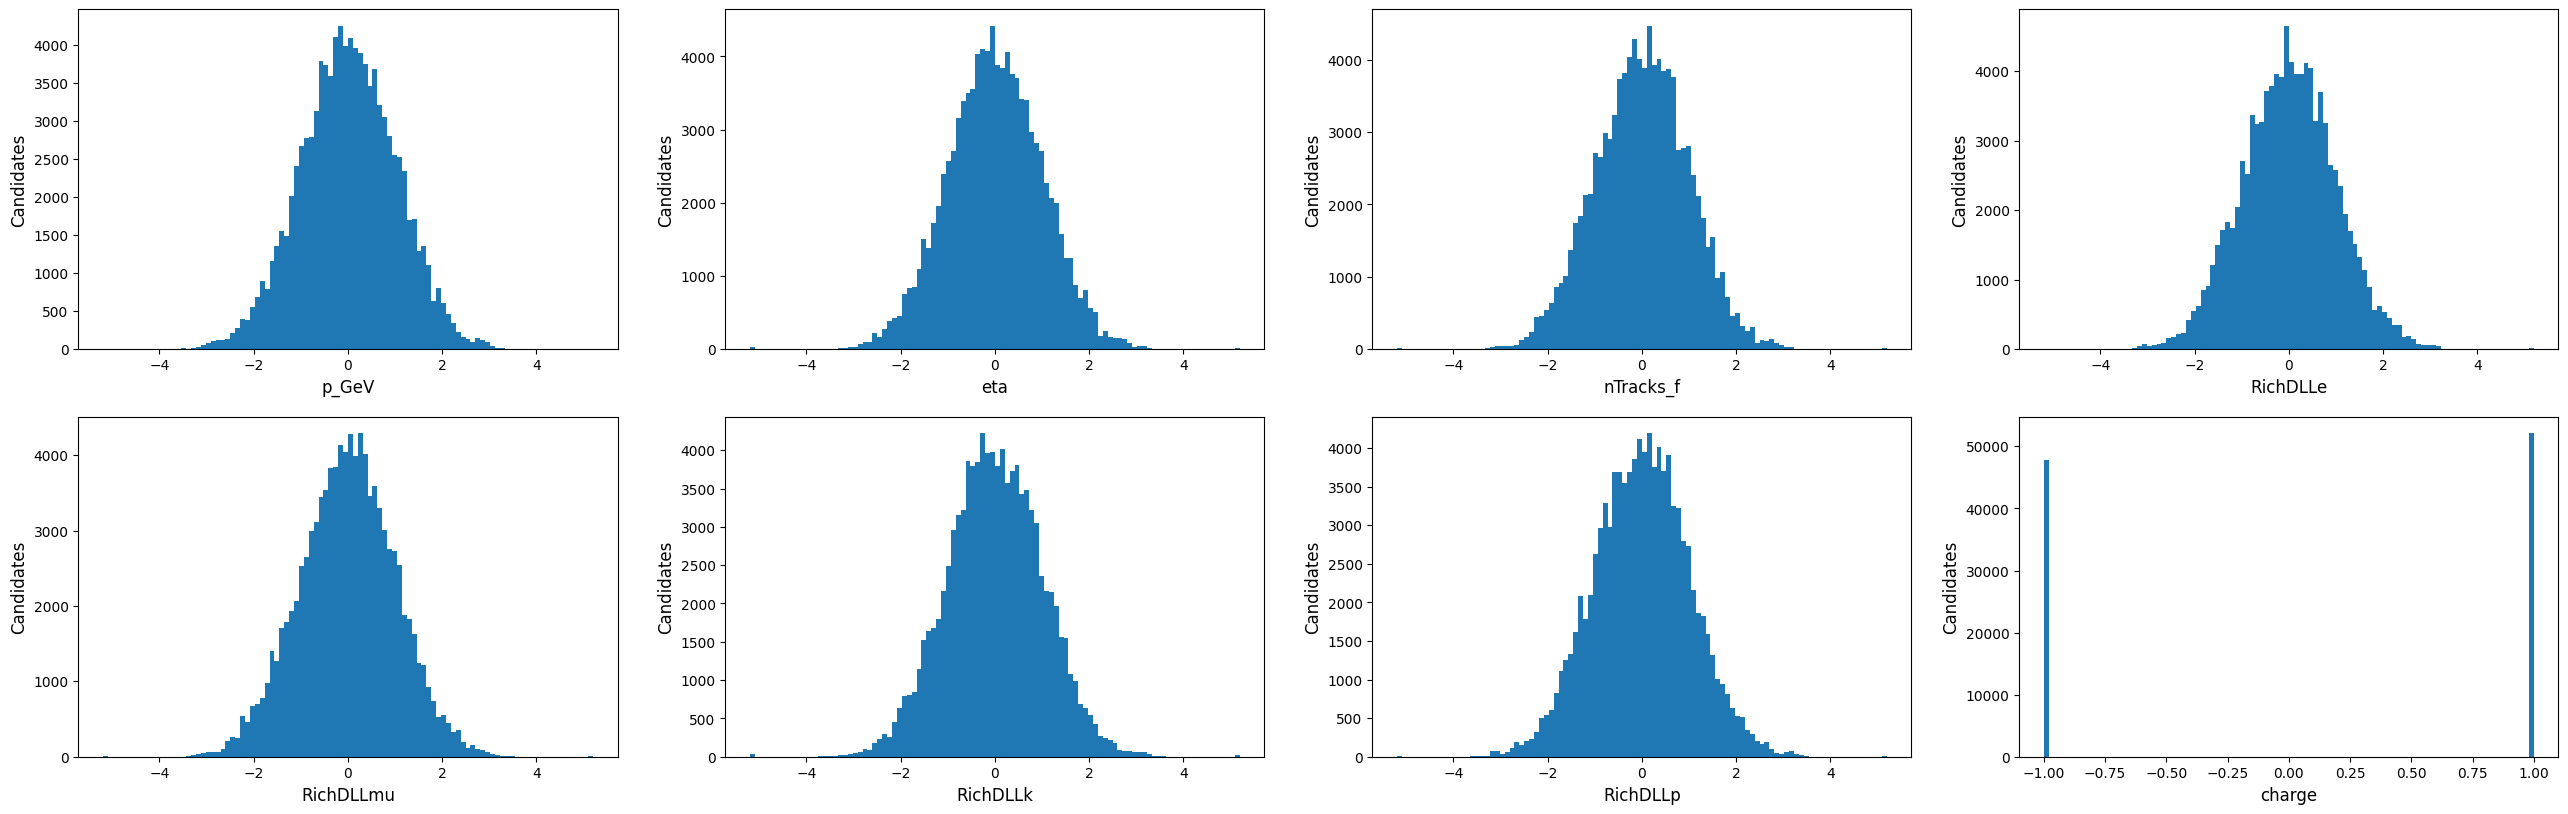

In [74]:
plt.figure(figsize=(32, 15), dpi=100)

for i, x_var in enumerate(conditions_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_p[:, i].numpy()[:100000], bins=100)

plt.show()

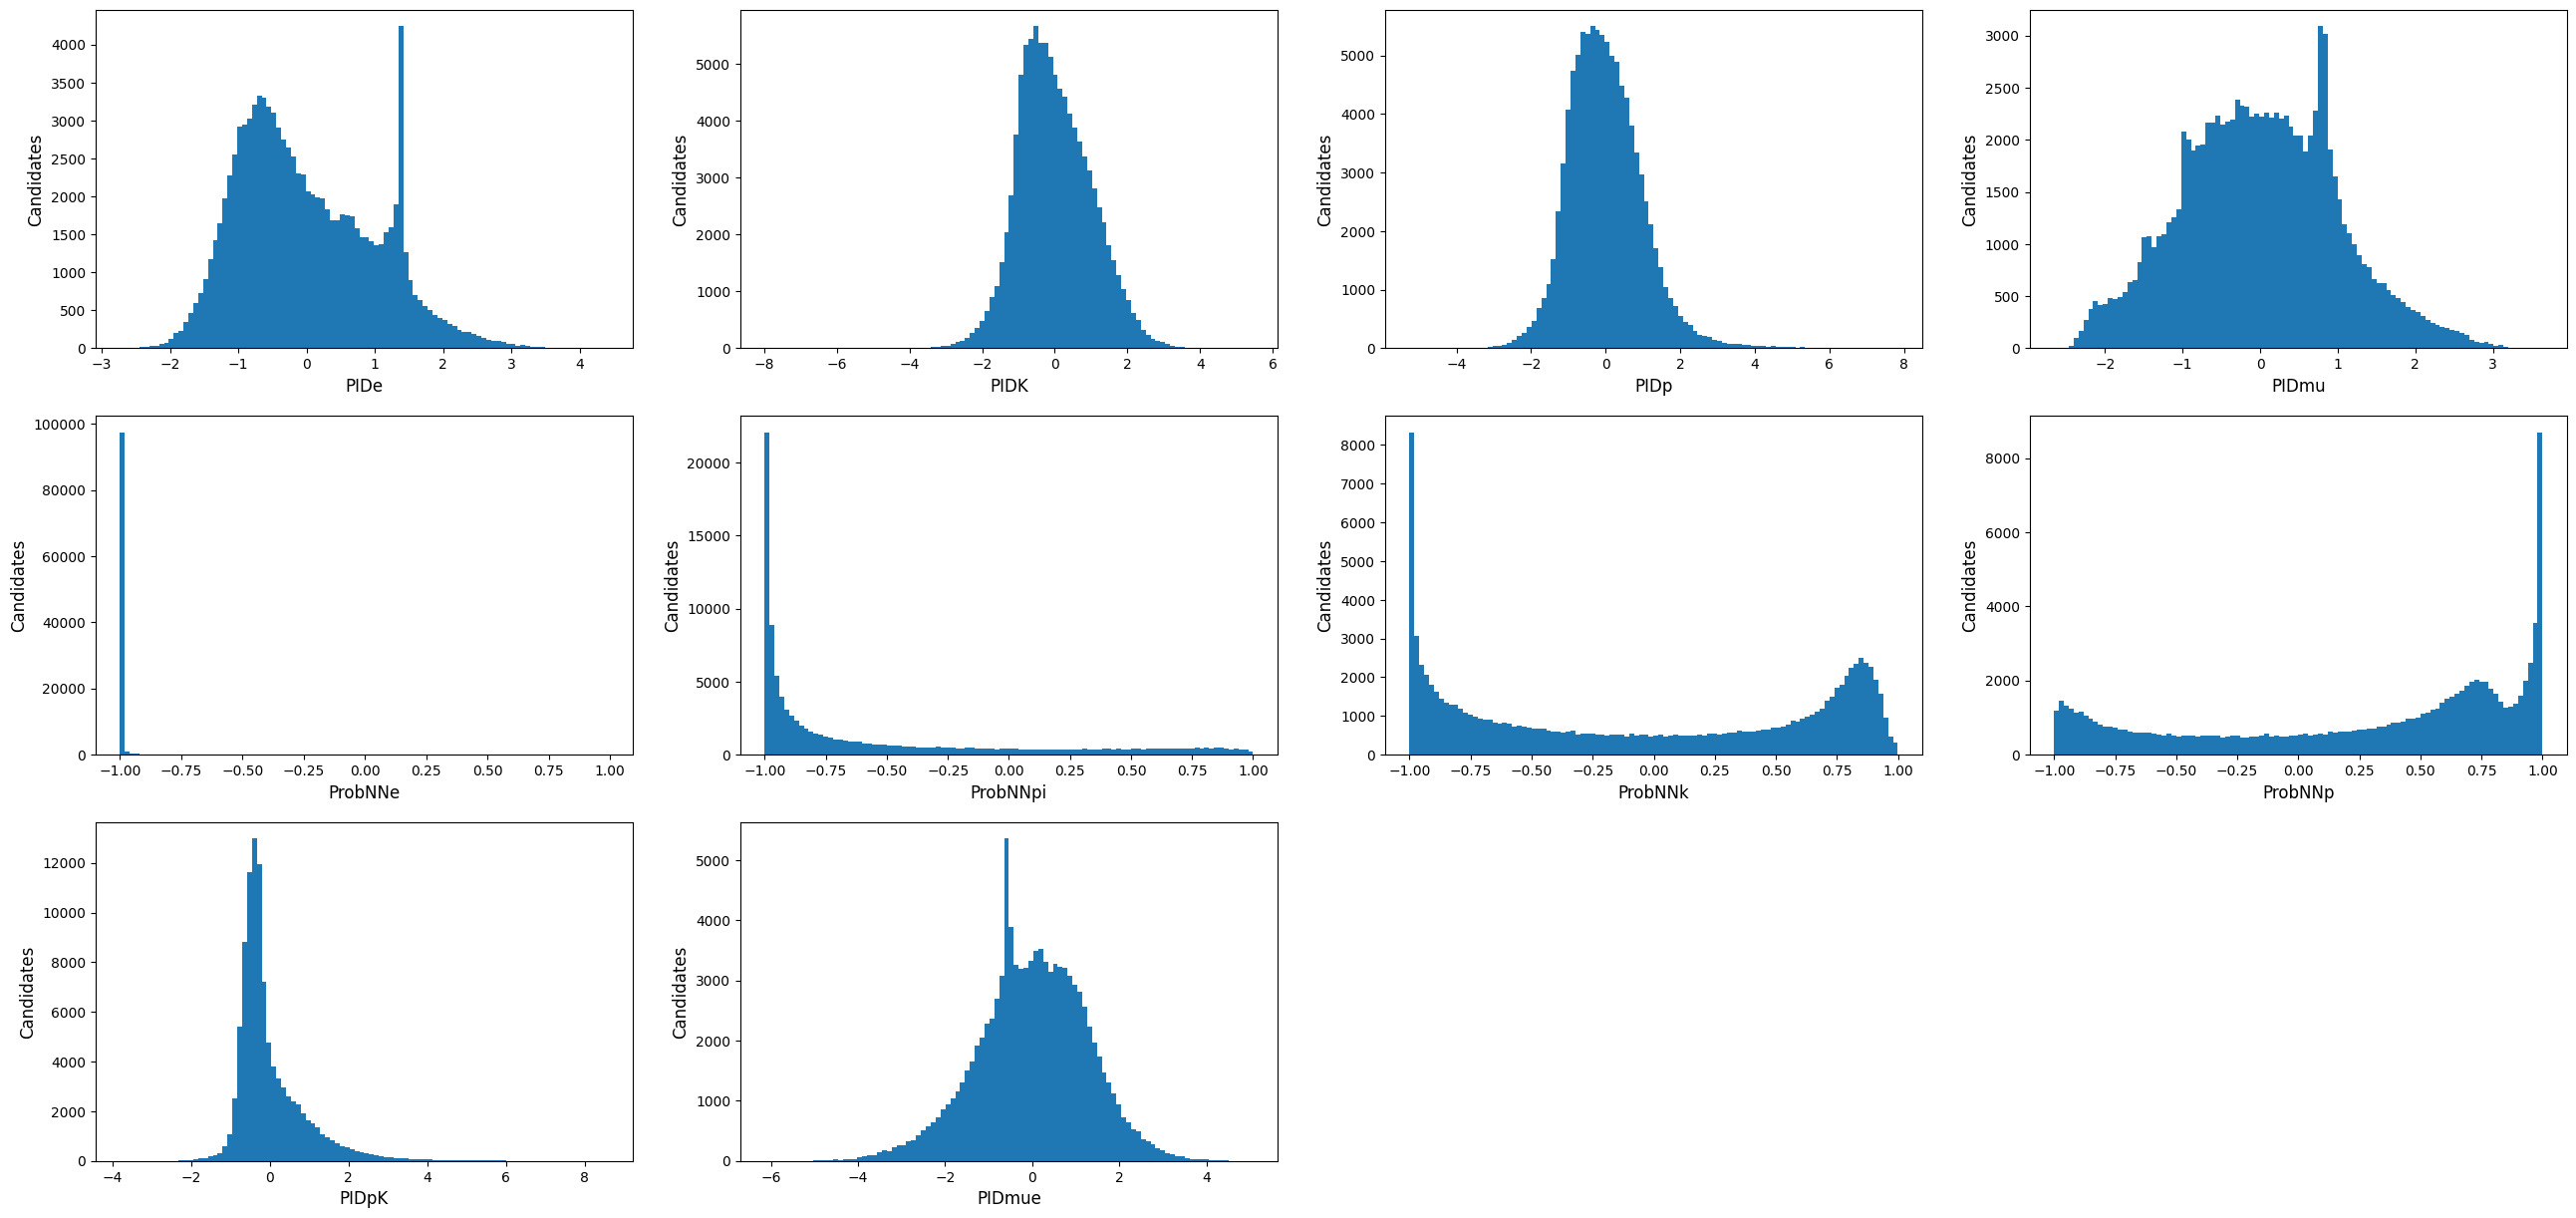

In [75]:
plt.figure(figsize=(32, 15), dpi=100)

for i, y_var in enumerate(reord_target_nm):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_p[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 9)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_p[:, 2].numpy()[:100000] - y_p[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_p[:, 3].numpy()[:100000] - y_p[:, 0].numpy()[:100000], bins=100)

plt.show()

In [76]:
np.savez_compressed(
    file=f"{DATA_PATH}/GlobalPID-nm-proton-{SAMPLE}-trainset.npz",
    x=X_p.numpy(),
    x_vars=conditions_nm,
    y=y_p.numpy(),
    y_vars=target_nm,
    w=None,
    w_var=None,
)